# Data Statistics and Evaluation

In the following demo, we will:
* Calculate total number of hours recorded for each site and locate files which could not be read with TuneR's readwave function.
* Calculate Summary Statistcs for each Bioacoustic Index
* Visualization of Indices
* Cluster Analysis (for indices)
* Correlation Analysis (for indices)
* Cluster Analysis following Correlation Analysis. 

First we install the necessary packages and set the width/height of the plots:

In [27]:
library(tuneR)
library(tidyr)
library(ggplot2)
library(factoextra)
library(cluster)
library(plyr)
library(repr)
library(cowplot)
library(TSdist)
library(mclust)
options(repr.plot.width=15, repr.plot.height=8)

Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.



## Basic Sound Data Statistics and Data 

The following code gives the hours recorded at each site (along with the total. Uncommenting the the expressions in the warning/error brackets also gives the files which could not be processed using TuneR's readWave function along with why the function fails (8 failed files). Errors include:
* bin-reading error(2 files): ``` <simpleError in readBin(con, int, n = 4, size = 1, endian = "little", signed = FALSE) %*% 2^c(0, 8, 16, 24): non-conformable arguments> ```
* char-reading error(3 files): ``` <simpleError in readChar(con, 4): invalid UTF-8 input in readChar()> ```
* non-valid WAVE file(3 files): ``` <simpleError in readWave(soundfile, header = TRUE): This seems not to be a valid RIFF file of type WAVE.> ```


As shown below there is about 1,260 hours of usable recorded sound.

In [7]:
DATA_LIBRARY_PATH<- "/media/colton/My Passport/data_library"
file.paths <- list.files(DATA_LIBRARY_PATH)
total <- 0
nonproblem_files <- 0
total_files <- 0
for (i in 1:length(file.paths)){
  duration <- 0
  sitepath <- paste(DATA_LIBRARY_PATH,file.paths[i],sep='/')
  sitefiles <- list.files(sitepath,recursive=TRUE, pattern = "wav$")
  for (j in 1:length(sitefiles)){
    soundfile <- paste(sitepath,sitefiles[j],sep='/')
    total_files <- total_files + 1
    result <- tryCatch(expr={
    hdr <- readWave(soundfile,header=TRUE)
    sr <- hdr$sample.rate
    samples<-hdr$samples
    duration <- duration + samples/(sr*3600)
    nonproblem_files <- nonproblem_files + 1
    }, warning = function(w) {
      #print(w)
      #print(soundfile)
    }, error = function(e) {
      #print(e)
      #print(soundfile)
    })
}
  total <- duration + total
  print(paste(paste(file.paths[i],duration,sep=": "),"hours"))
}
print(paste("Total",total,sep=": "))
print(paste("Non-Problem Files",nonproblem_files,sep=": "))
print(paste("Total Files",total_files,sep=": "))

[1] "Audubon_Society: 29.3517748148148 hours"
[1] "Biosphere_2: 27.2658311111111 hours"
[1] "Chuparosa_Inn: 21.59808 hours"
[1] "Desert_museum: 39.1802755555556 hours"
[1] "Empire_Ranch: 24.7657748148148 hours"
[1] "Gates Pass: 123.29344 hours"
[1] "Jake: 91.3273303703704 hours"
[1] "Nirav: 95.5661096296297 hours"
[1] "Patagonia_lake: 25.5610548148148 hours"
[1] "Paton_Hummingbird: 24.87544 hours"
[1] "Proctor_road: 24.993522962963 hours"
[1] "Ruth: 111.326684444445 hours"
[1] "Sabino_canyon: 50.0686074074074 hours"
[1] "Saguaro_NP: 136.065831111111 hours"
[1] "Silvestrer_Spring: 24.6300503703704 hours"
[1] "Sweetwater: 140.433386666667 hours"
[1] "Theresa: 105.168971851852 hours"
[1] "Tumamoc: 163.181576296296 hours"
[1] "Total: 1258.65374222222"
[1] "Non-Problem Files: 1301"
[1] "Total Files: 1309"


## Index Stats and Clustering Analysis
The calculated indices are read in from a CSV(comma separated values) file.  The first six rows of the dataframe are shown below.

In [8]:
INDEX_CSV <- "/media/colton/My Passport/new_final.csv"
index_data <- read.csv(INDEX_CSV,header=TRUE)
head(index_data)

Site            Date....as.Date.character....format.....Y..m..d..
1 Audubon_Society 2019-04-18                                       
2 Audubon_Society 2019-04-18                                       
3 Audubon_Society 2019-04-18                                       
4 Audubon_Society 2019-04-18                                       
5 Audubon_Society 2019-04-18                                       
6 Audubon_Society 2019-04-18                                       
  Time....character.. Name....character..                         
1 11:12:36            Audubon_Society_S4A07275_20190418_111236.wav
2 11:17:36            Audubon_Society_S4A07275_20190418_111236.wav
3 11:22:36            Audubon_Society_S4A07275_20190418_111236.wav
4 11:27:36            Audubon_Society_S4A07275_20190418_111236.wav
5 11:32:36            Audubon_Society_S4A07275_20190418_111236.wav
6 11:37:36            Audubon_Society_S4A07275_20190418_111236.wav
  File_Start_Time....character.. File_End_Time....character..
1  0                              5                          
2  5                             10                          
3 10                             15                          
4 15                             20                          
5 20                             25                          
6 25                             30                          
  bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1 101.0132                0.09830943            0.9724801                   
2 113.4433                0.11335600            0.9730184                   
3 125.1966                0.20363086            0.9820155                   
4 147.6329                0.16143239            0.9848378                   
5 120.6462                0.18025170            0.9826372                   
6 150.6320                0.09876261            0.9809657                   
  spectral_entropy....double.. acoustic_entropy....double..
1 0.8142960                    0.7918867                   
2 0.8080708                    0.7862678                   
3 0.7945508                    0.7802612                   
4 0.7754547                    0.7636971                   
5 0.7972910                    0.7834478                   
6 0.7997804                    0.7845571                   
  acoustic_diversity....double.. acoustic_evenness....double..
1 1.811299                       0.514931                     
2 1.767159                       0.539738                     
3 1.744127                       0.557559                     
4 1.768792                       0.530202                     
5 1.733753                       0.558135                     
6 1.580442                       0.617017                     
  acoustic_complexity....double.. nrows....double.. ndsi....double..
1 196.6844                        1                 0.4799106       
2 201.1060                        0                 0.8579672       
3 196.8785                        0                 0.5911719       
4 211.8268                        0                 0.8497890       
5 199.5438                        1                 0.5483259       
6 191.5337                        0                 0.7192530

A generic histogram is plotted for each of the alpha indices.

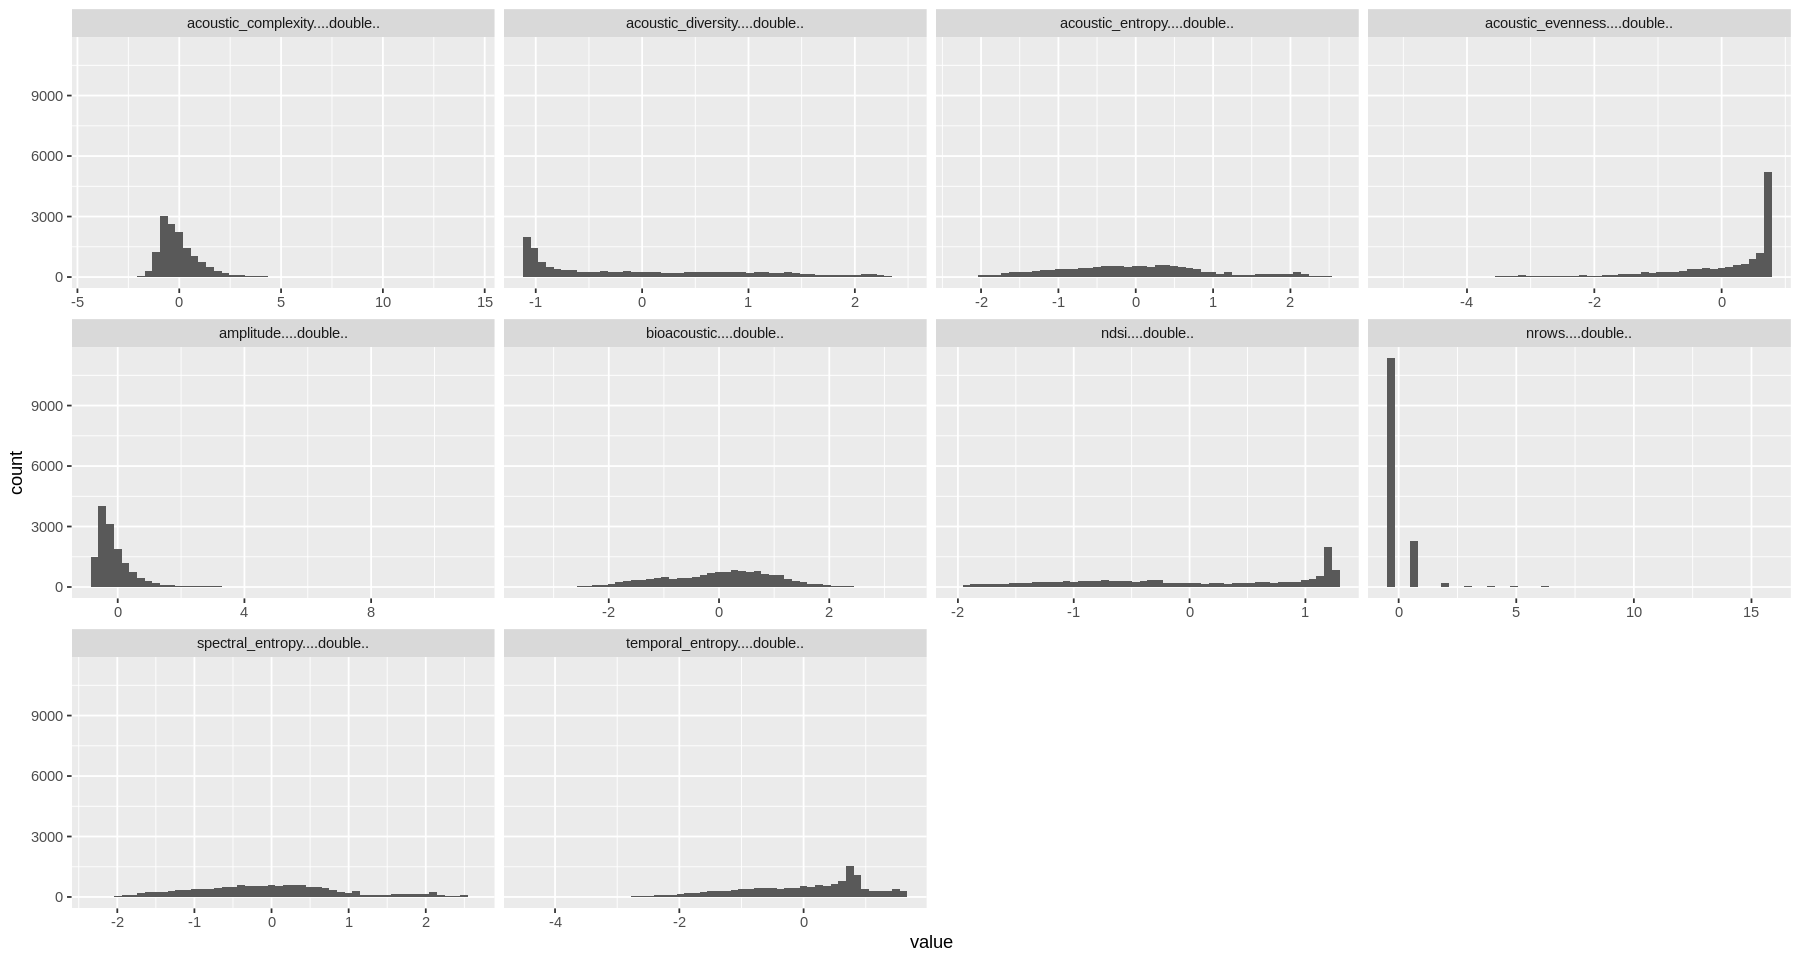

In [38]:
ggplot(gather(index_data[,7:16]), aes(value)) + 
    geom_histogram(bins = 50) + 
    facet_wrap(~key, scales = 'free_x')

Basic Summarization Statistics are given for each of the alpha indices.

In [10]:
summary(index_data)
#colnames(index_data)

            Site      Date....as.Date.character....format.....Y..m..d..
 Tumamoc_NA   :1827   2019-04-14:  542                                 
 Sweetwater_NA:1571   2018-09-07:  528                                 
 Saguaro_NP   :1522   2018-09-08:  528                                 
 Gates_Pass   :1379   2019-06-09:  528                                 
 Ruth_NA      :1231   2019-06-10:  528                                 
 Theresa_NA   :1197   2019-06-11:  528                                 
 (Other)      :5366   (Other)   :10911                                 
 Time....character..                           Name....character..
 15:0:0 :   54       Theresa_S4A07341_20180824_020000.wav:   12   
 15:10:0:   53       Theresa_S4A07341_20180824_060000.wav:   12   
 15:15:0:   53       Theresa_S4A07341_20180824_071000.wav:   12   
 15:5:0 :   53       Theresa_S4A07341_20180824_082000.wav:   12   
 2:0:0  :   53       Theresa_S4A07341_20180824_093000.wav:   12   
 2:10:0 :   53       T

## Clustering/PCA

First, we scale the data:

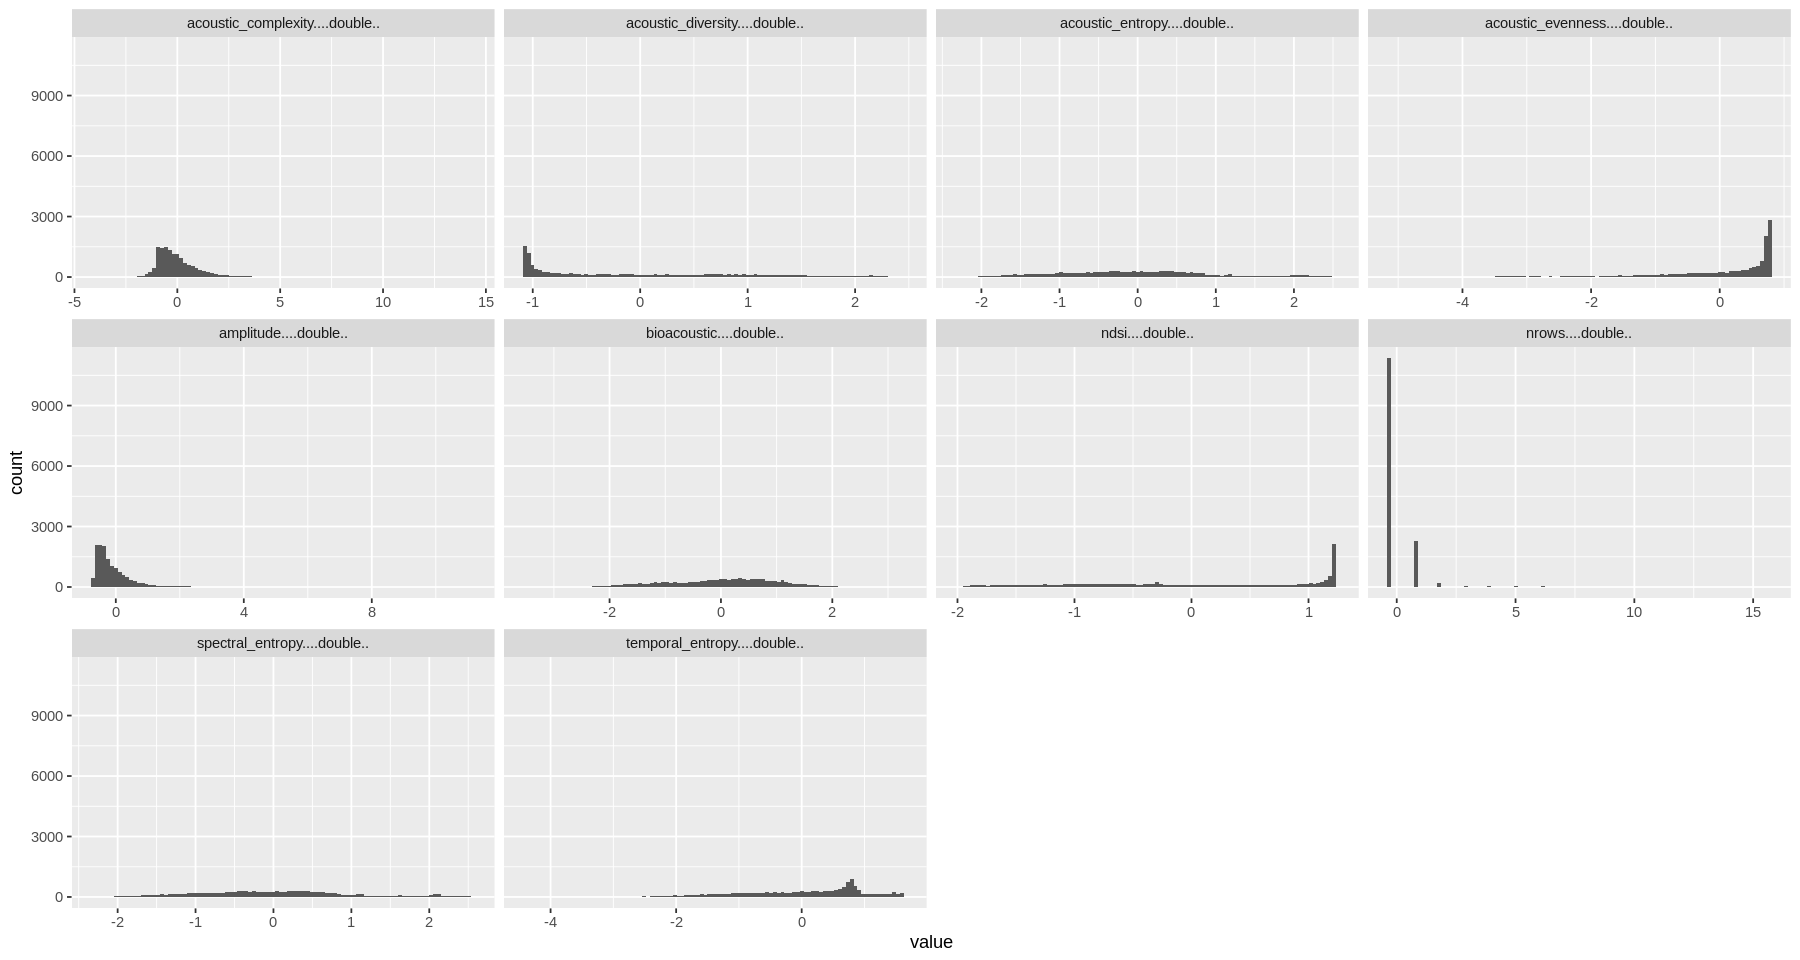

In [28]:
index_data[,7:16] <- scale(index_data[,7:16])
ggplot(gather(index_data[,7:16]), aes(value)) + 
    geom_histogram(bins = 100) + 
    facet_wrap(~key, scales = 'free_x')


Using the average silhouette metric, we see that two is the most natural clustering, with a local maximum of average silhoutte at 10 clusters. 

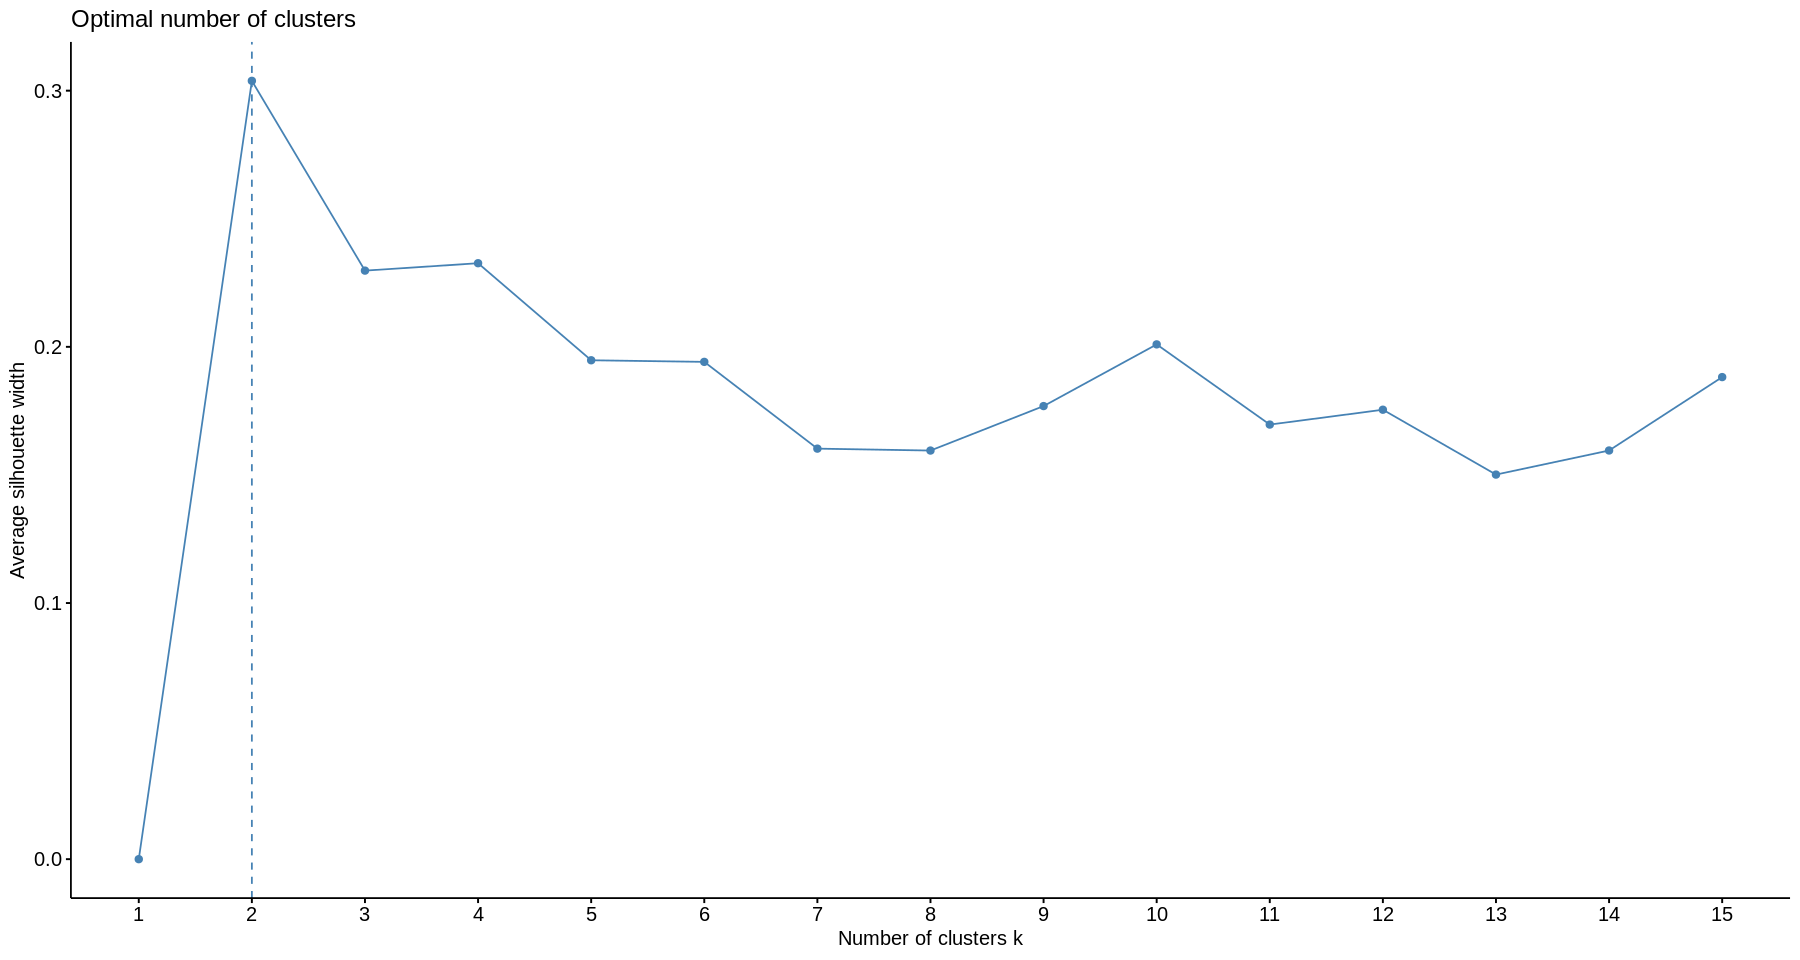

In [12]:
fviz_nbclust(index_data[,7:16],FUNcluster=clara,method = "silhouette",k.max=15,verbose=TRUE)

The cluster sizes and means of a clustering with 10 clusters are given below, along with a two-dimensional graph of the clusters with the two-dimensions given by the first two principal components:

A histogram indicating the frequency of the hour of the recording in each cluster given below(a histogram for every cluster).

In [13]:
file_adder <- function(name,start,end,dest_folder,site,date,time) {
    data_path <- "/media/colton/My Passport/data_library"
    file_directory <- list.files(data_path,recursive=TRUE,pattern=".wav")
    if (!dir.exists(dest_folder)) {
        dir.create(dest_folder)
    }
    for(i in 1:length(file_directory)){
        if (tail(unlist(strsplit(file_directory[i], "/")),n=1)==name)
        {
            name <- paste(site,date,paste(time,".wav",sep=''),sep="_")
            file <- paste(data_path,file_directory[i],sep="/")
            selection <- readWave(file,from=start,to=end,units='minutes')
            writeWave(selection, paste(dest_folder,name,sep="/"))
            }
    }
    
}

In [24]:
splitter <- function(x) {return(strsplit(x,":")[[1]][1])}
month_getter<- function(x) {return(as.numeric(strsplit(as.character(x),"-")[[1]][2]))}
'%notin%' <- Negate(`%in%`)
euclidean <- function(cluster,center,clust_num) {
    square_dist <- 0
    for (index in 1:10) {
        #print(as.numeric(as.character(cluster[,3+index])))
        #print(as.numeric(as.character(center[num_clusters,index])))
        square_dist <- square_dist + (as.numeric(as.character(cluster[,6+index]))-as.numeric(as.character(center[clust_num,index])))^2
    }
    return(sqrt(square_dist))
}
histogram_plotter <- function(fit,data) {
    sites<-unique(index_data$Site)
    times<-c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
    months<-c(1,2,3,4,5,6,7,8,9,10,11,12)
    total_site_counts <- data %>% 
             count(vars = c("Site")) 
    dest_folder<-paste("clustering",as.character(length(fit$size)),"centers",sep='_')
for (i in 1:length(fit$size)){
    cluster <- subset(data, fit.cluster==as.character(i))
    cluster
    cluster$hr <- sapply(as.character(cluster$Time....character..),splitter)
    cluster$month <- sapply(cluster$Date....as.Date.character....format.....Y..m..d..,month_getter)
    time_counts <- cluster %>% 
                count(vars = c("hr"))
    for (time in times){
        if (time %notin% unique(time_counts$hr)){
            time_counts<-rbind(time_counts,c(time,0))
        }        
    }
    
    time_counts = mutate(time_counts,hr=factor(hr, levels=times))
    month_counts <- cluster %>% 
            count(vars = c("month"))
    for (month in months){
        if (month %notin% unique(month_counts$month)){
            time_counts<-rbind(time_counts,c(time,0))
        }        
    }
    
    month_counts = mutate(month_counts,month=factor(month, levels=times))
    site_counts <- cluster %>% 
                count(vars = c("Site")) 
    for (site in sites){
        if (site %notin% unique(site_counts$Site)){
            site_counts<-rbind(site_counts,c(site,0))
        }        
    }
    site_counts <- merge(site_counts,total_site_counts,by="Site")
    #site_counts <- site_counts %>% mutate(percent=site_counts[freq.x/freq.y)
    
    site_counts <- transform(site_counts, percent = as.numeric(freq.x) / as.numeric(freq.y))
    cluster <- mutate(cluster,dist=euclidean(cluster,fit$centers,i))
    closest <- cluster[which.min(cluster$dist), ]
    
    if (strsplit(as.character(closest$Site[1]),"_")[[1]][2]=="NA") {
        site <- strsplit(as.character(closest$Site[1]),"_")[[1]][1]
    }
    else {
        site <-as.character(closest$Site[1])
    }
    name <-as.character(closest$Name....character..[1]) 
    split_name <- tail(unlist(strsplit(name, "_")),n=3)
    whole_name <- as.character(paste(split_name[1],split_name[2],split_name[3],sep="_"))
    start<- as.numeric(closest$File_Start_Time....character..[1])
    end<- as.numeric(closest$File_End_Time....character..[1])
    date <- as.character(closest$Date....as.Date.character....format.....Y..m..d..[1])
    time <- as.character(closest$Time....character..[1]) 
    
    time_plot<-ggplot(time_counts) + geom_bar(aes(x = hr, y = freq), stat="identity") + ggtitle(paste("Time Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    site_plot<-ggplot(site_counts) + geom_bar(aes(x = Site, y = as.numeric(as.character(freq.x)) ), stat="identity") + ggtitle(paste("Site Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    percent_plot<-ggplot(site_counts) + geom_bar(aes(x = Site, y = percent), stat="identity") + ggtitle(paste("Percentage of Site Recordings within Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90)) + ylim(0, 1)
    month_plot<-ggplot(month_counts) + geom_bar(aes(x = month, y = freq), stat="identity") + ggtitle(paste("Month Frequency of Cluster with Center Closest to",site,date,time))+theme(axis.text.x = element_text(face = "bold", color = "#993333", 
                           size = 12, angle = 90))
    file_adder(whole_name,start,end,dest_folder,site,date,time)
    print(plot_grid(time_plot, site_plot,percent_plot,month_plot))
}
    
    }



[1] 3063 1514 3400  199  910   93 1908  916  481 1609

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1   0.52118573             -0.13688862            0.3635095                  
2  -1.19206651             -0.53814839            0.9932387                  
3   0.79835510             -0.34160112            0.6741316                  
4  -1.27612418              0.63860456           -0.1250311                  
5  -0.54603463             -0.02863559           -0.6221893                  
6  -1.04995436              8.25762575            0.6116065                  
7   0.01756289              0.03532992           -0.9079992                  
8  -1.21023087              0.27122578           -0.1432848                  
9  -0.07161038              2.58628003           -0.4343568                  
10 -0.34059570             -0.02072453           -1.4309568                  
   spectral_entropy....double.. acoustic_entropy....double..
1   0.0724992                    0.08434203                 
2  -1.0582216                   -1.03030536                 
3   0.4813120                    0.50685600                 
4   2.1943097                    2.17789272                 
5   1.6729315                    1.63213520                 
6  -1.1608817                   -1.14270834                 
7  -0.5864763                   -0.61462172                 
8   1.4282843                    1.41638308                 
9  -1.2256585                   -1.23392163                 
10 -1.0610451                   -1.09716089                 
   acoustic_diversity....double.. acoustic_evenness....double..
1  -0.4511268                      0.5093628                   
2  -0.6799152                      0.5943314                   
3   0.7597679                     -0.4560093                   
4   1.8667648                     -2.5228249                   
5   1.8347199                     -2.3206438                   
6  -0.5139932                      0.4598252                   
7  -0.9272884                      0.7153056                   
8   1.1910933                     -1.0300396                   
9  -0.8156312                      0.6472109                   
10 -0.6803942                      0.5773181                   
   acoustic_complexity....double.. nrows....double.. ndsi....double..
1  -0.35547615                     -0.16818031       -0.8897644      
2  -0.62846008                     -0.19784373       -0.0888889      
3  -0.05123488                      0.08903133        0.7407741      
4  -0.30818921                      6.69701076        1.0978216      
5   1.82983727                      0.02142383        1.0256204      
6   2.70885327                     -0.27183245       -0.6190162      
7  -0.13673089                     -0.27746631       -1.0542824      
8  -0.74556705                      0.26172868        1.1123260      
9   0.87166068                     -0.29334482       -0.2791610      
10  0.54898580                     -0.23877819        0.2324662

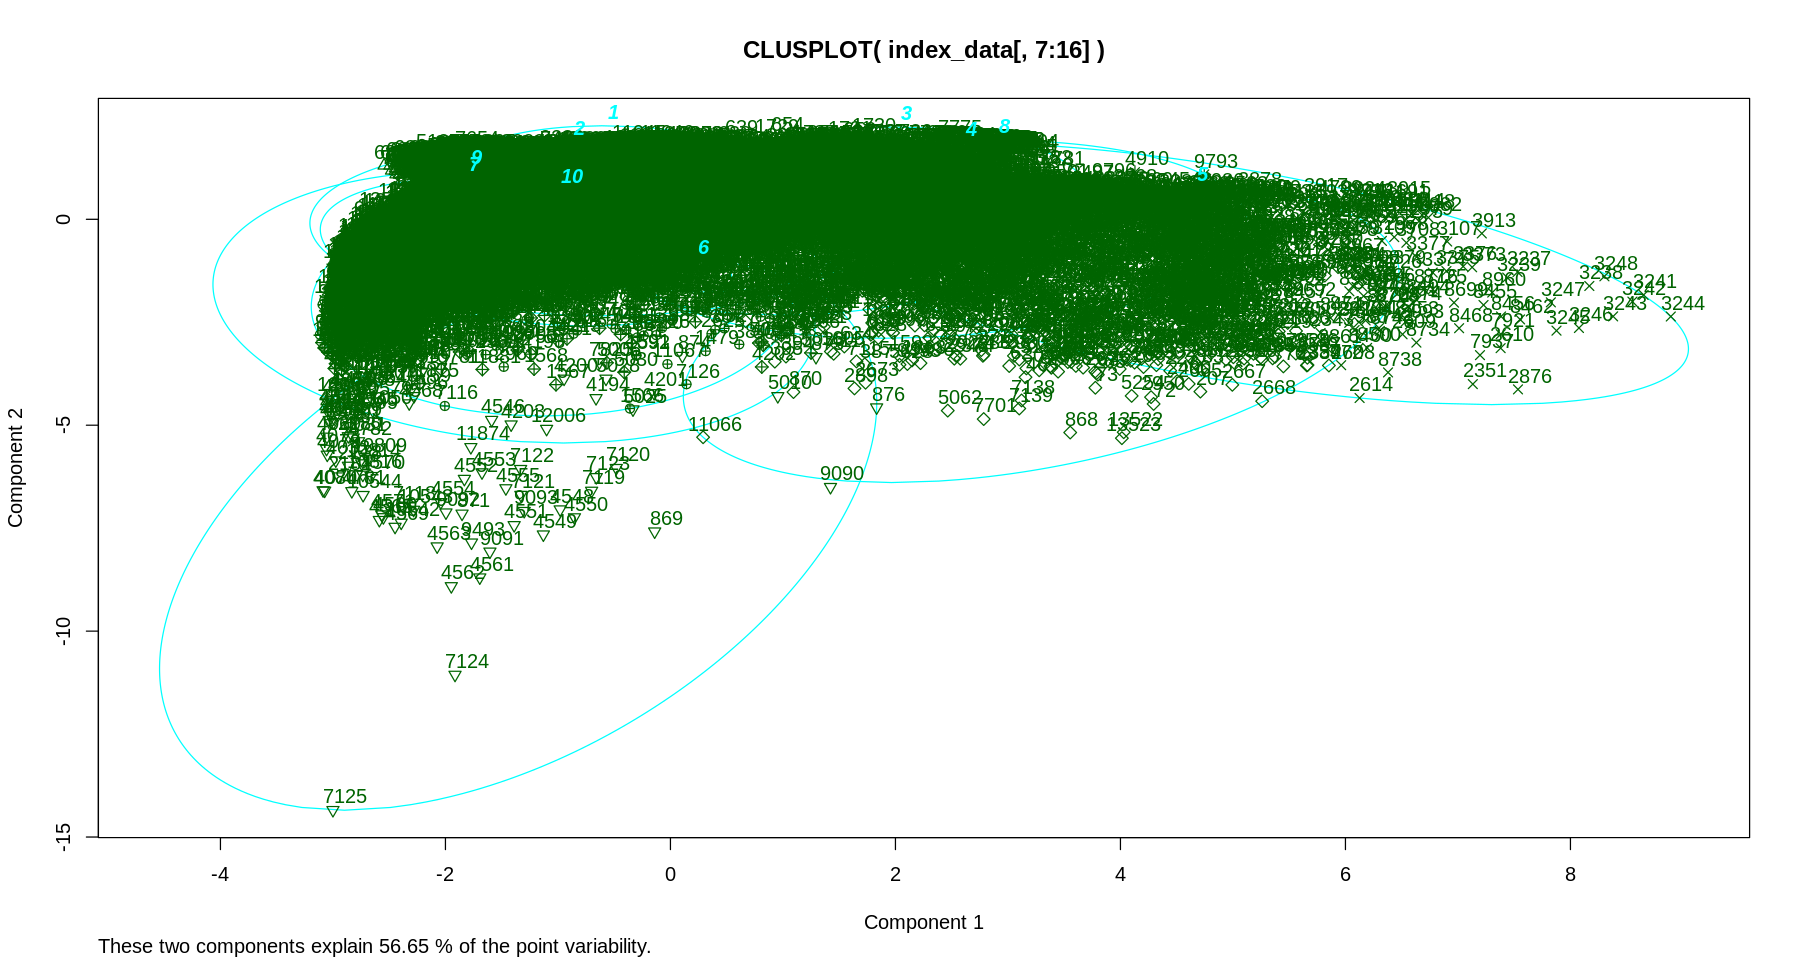

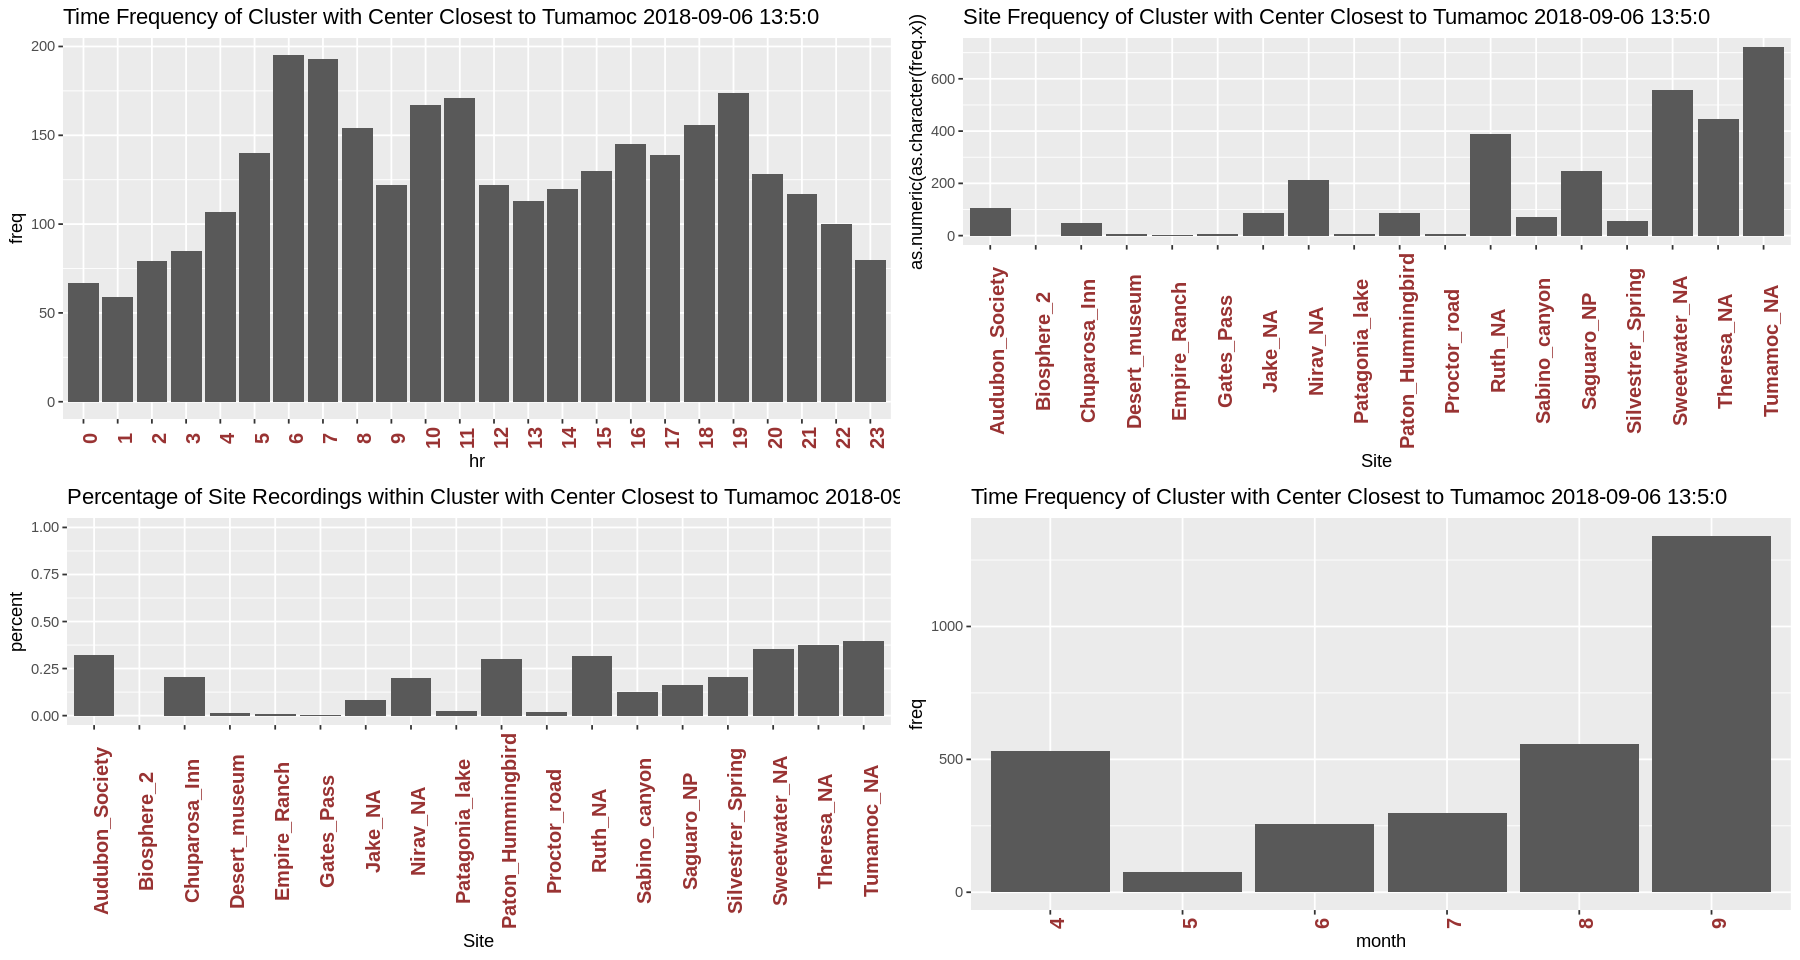

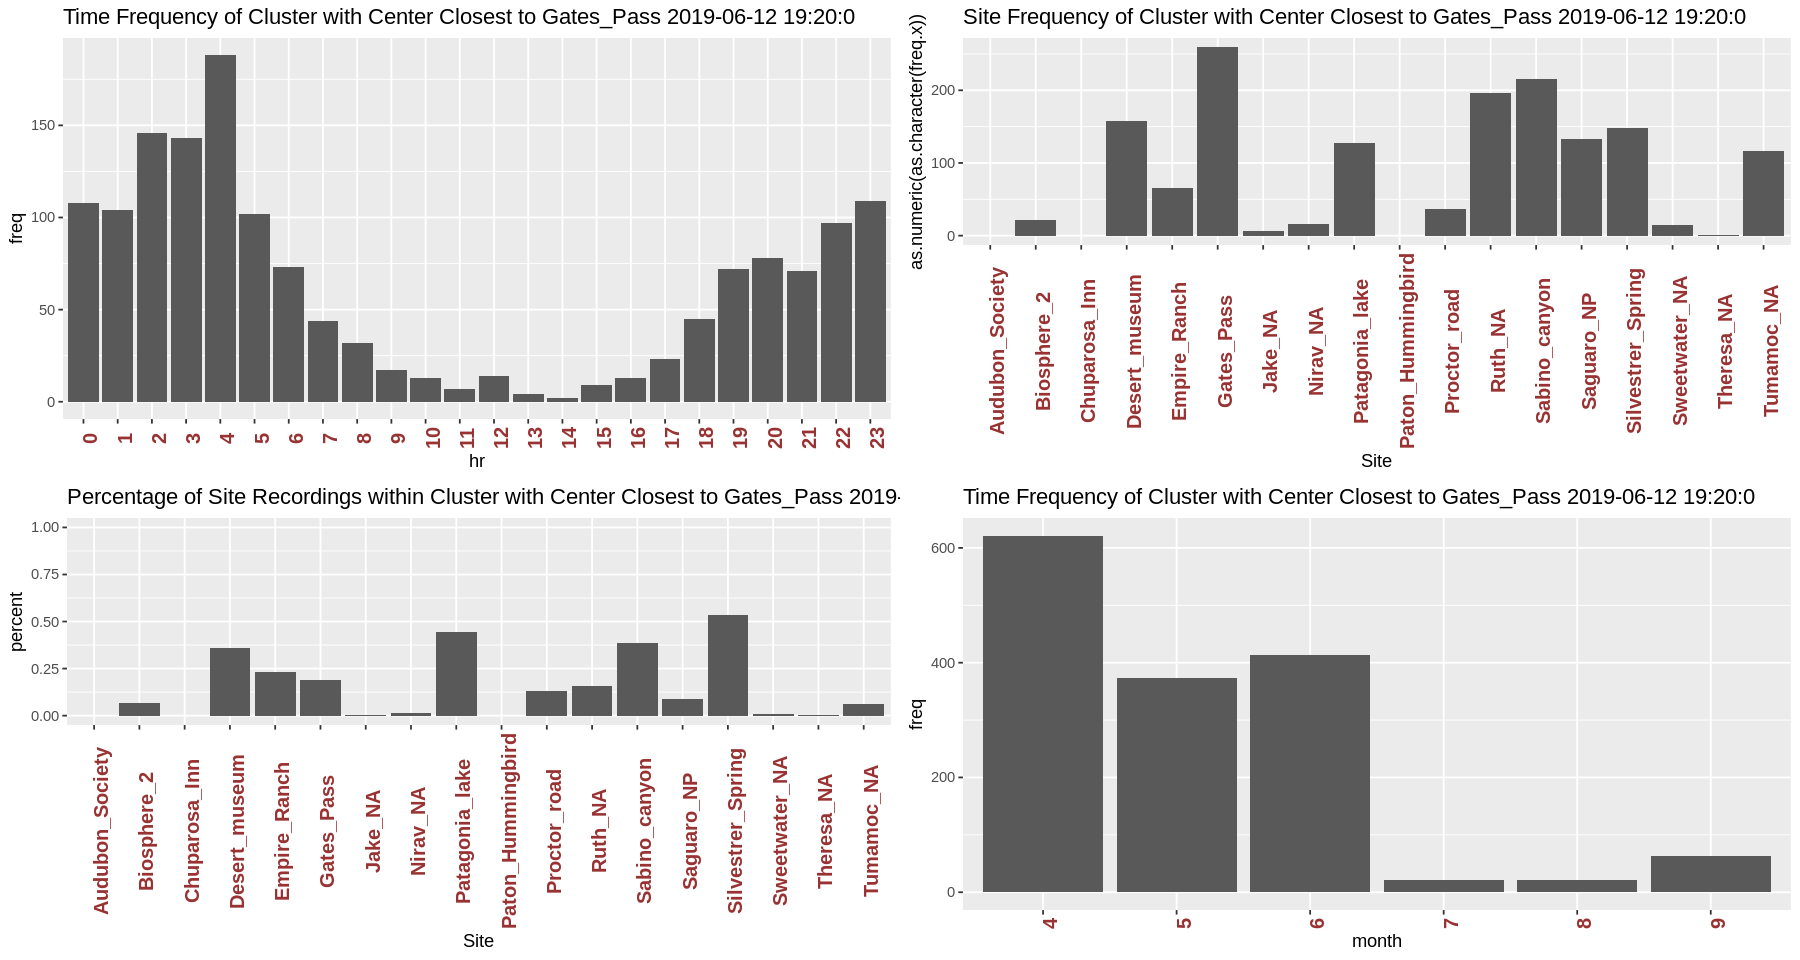

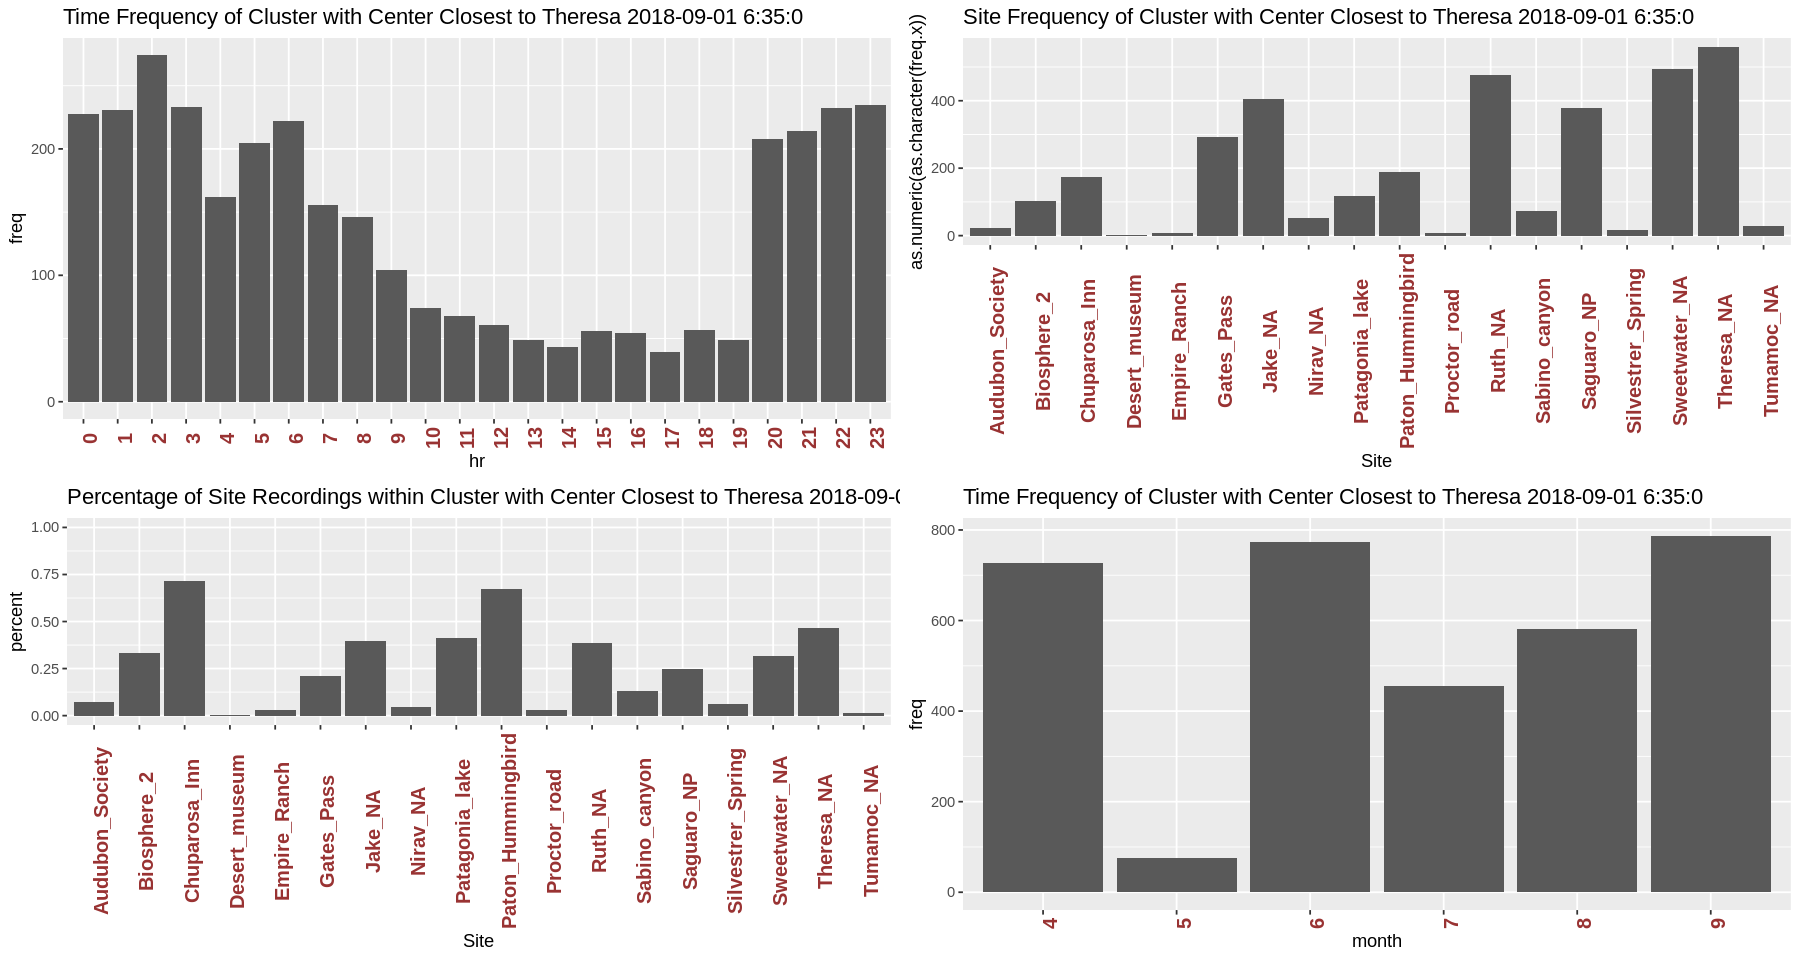

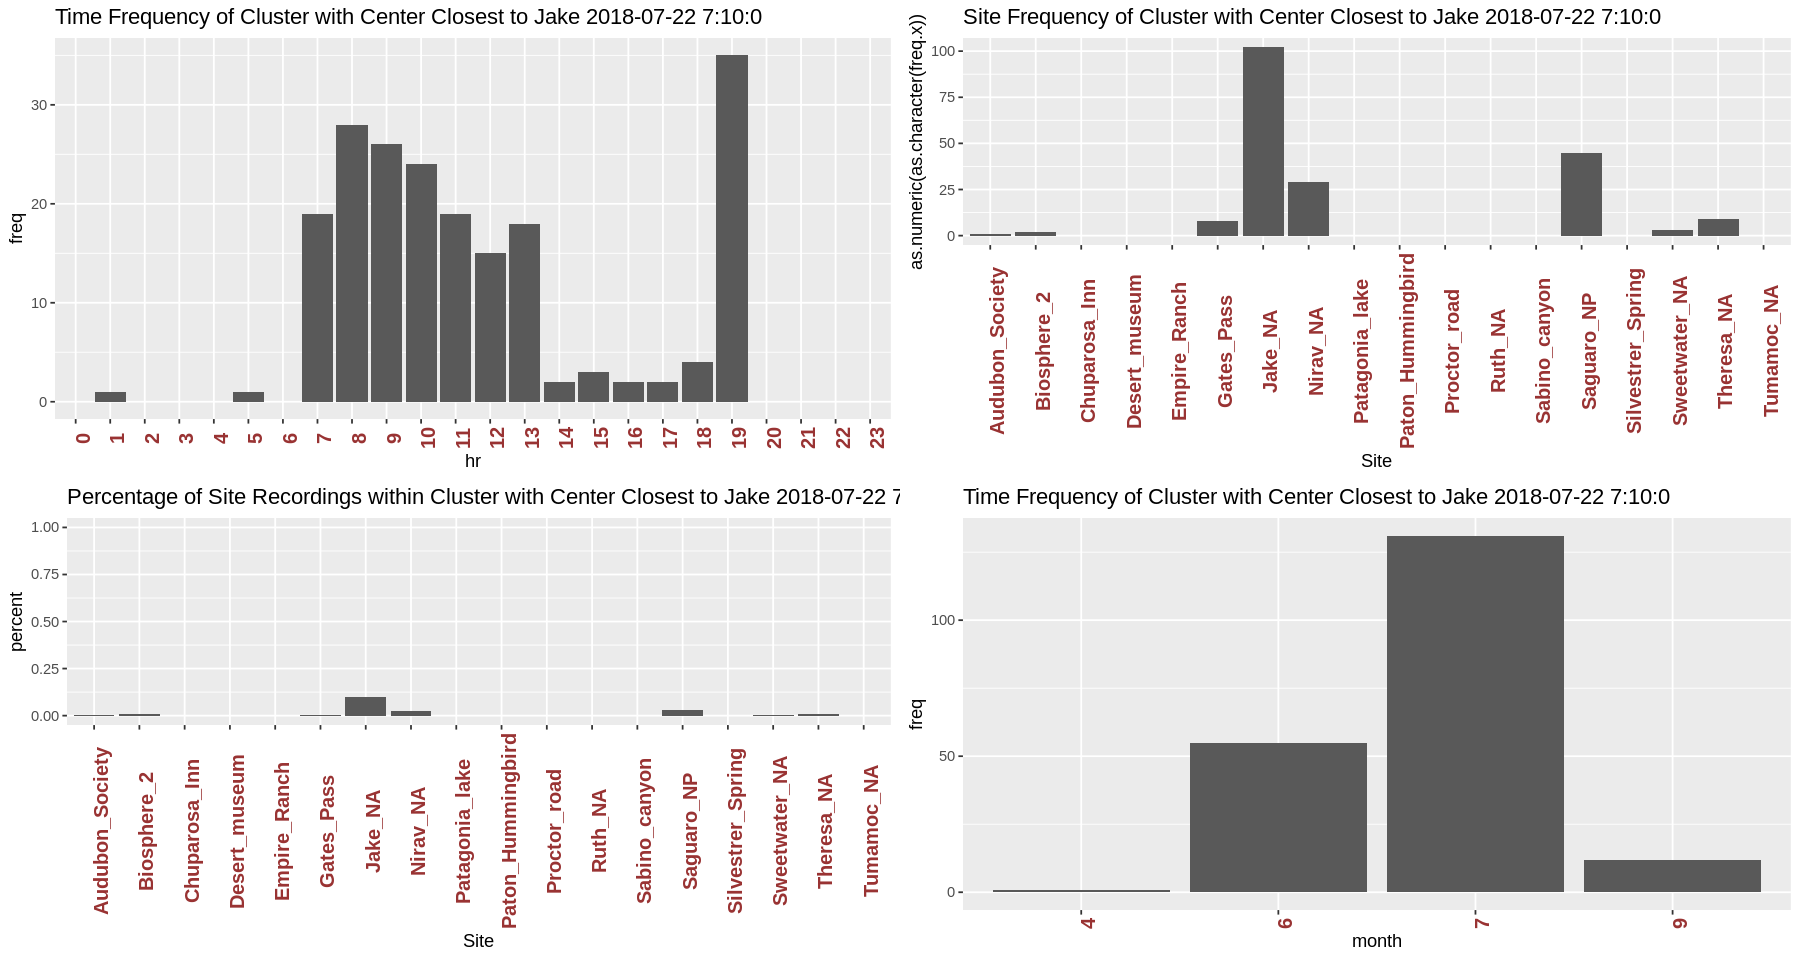

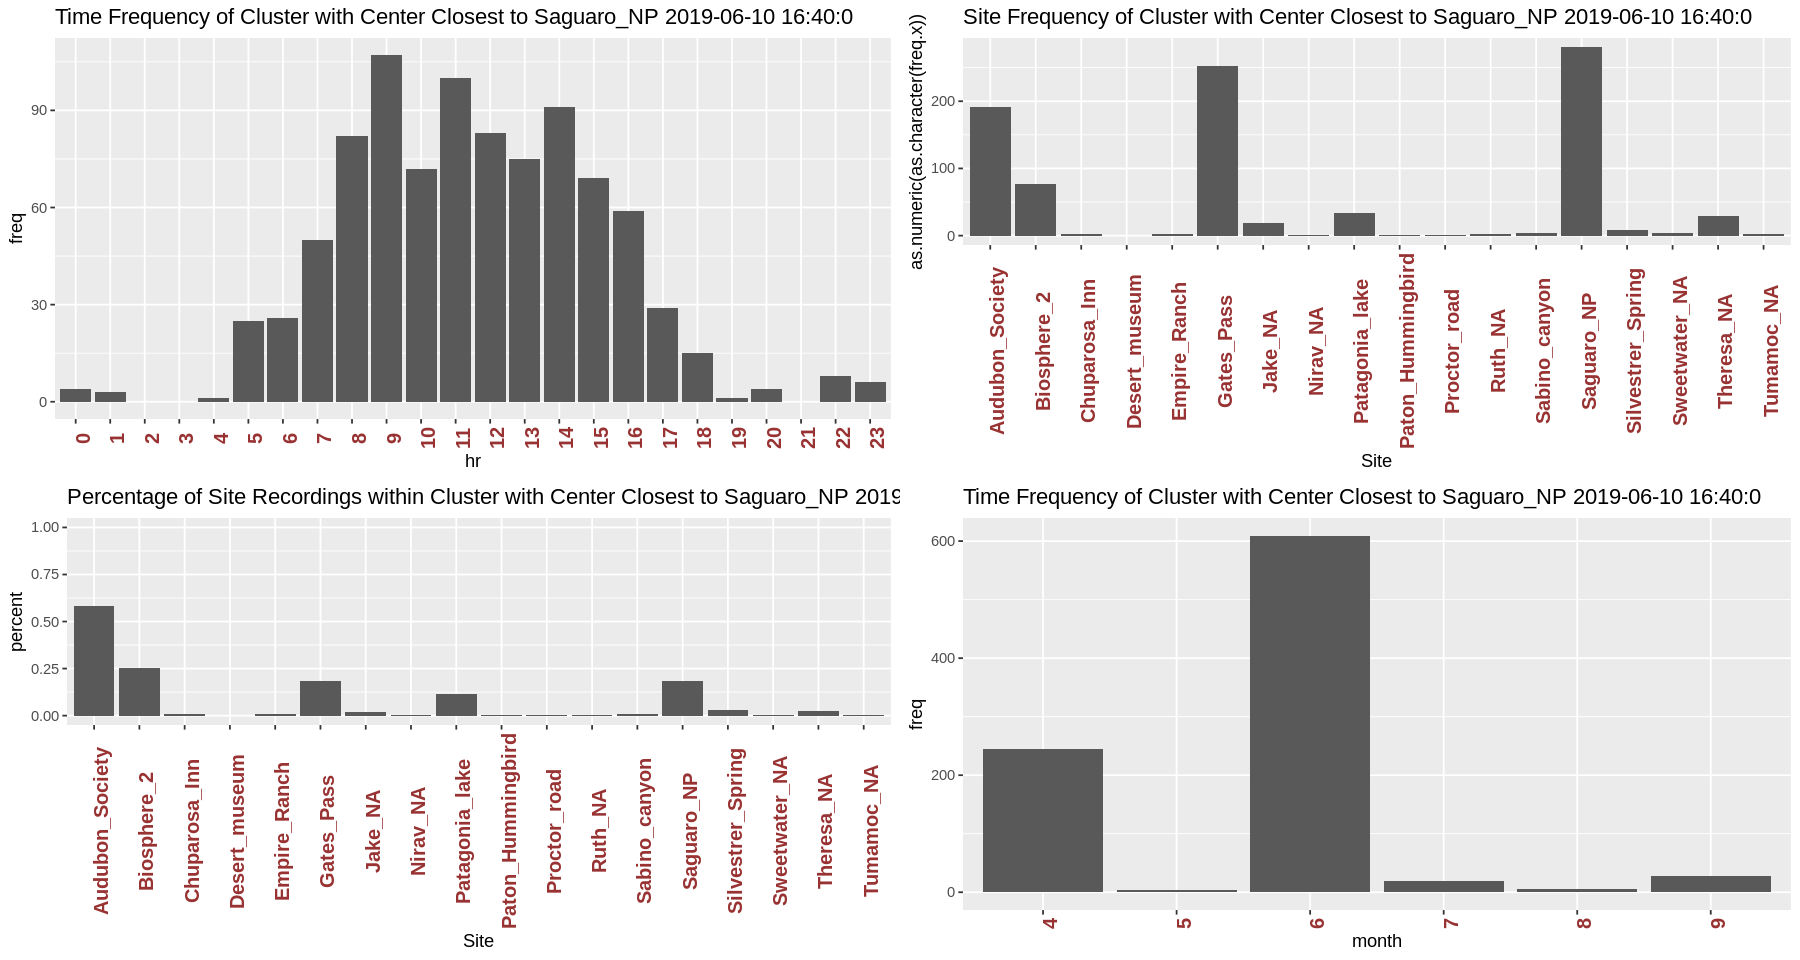

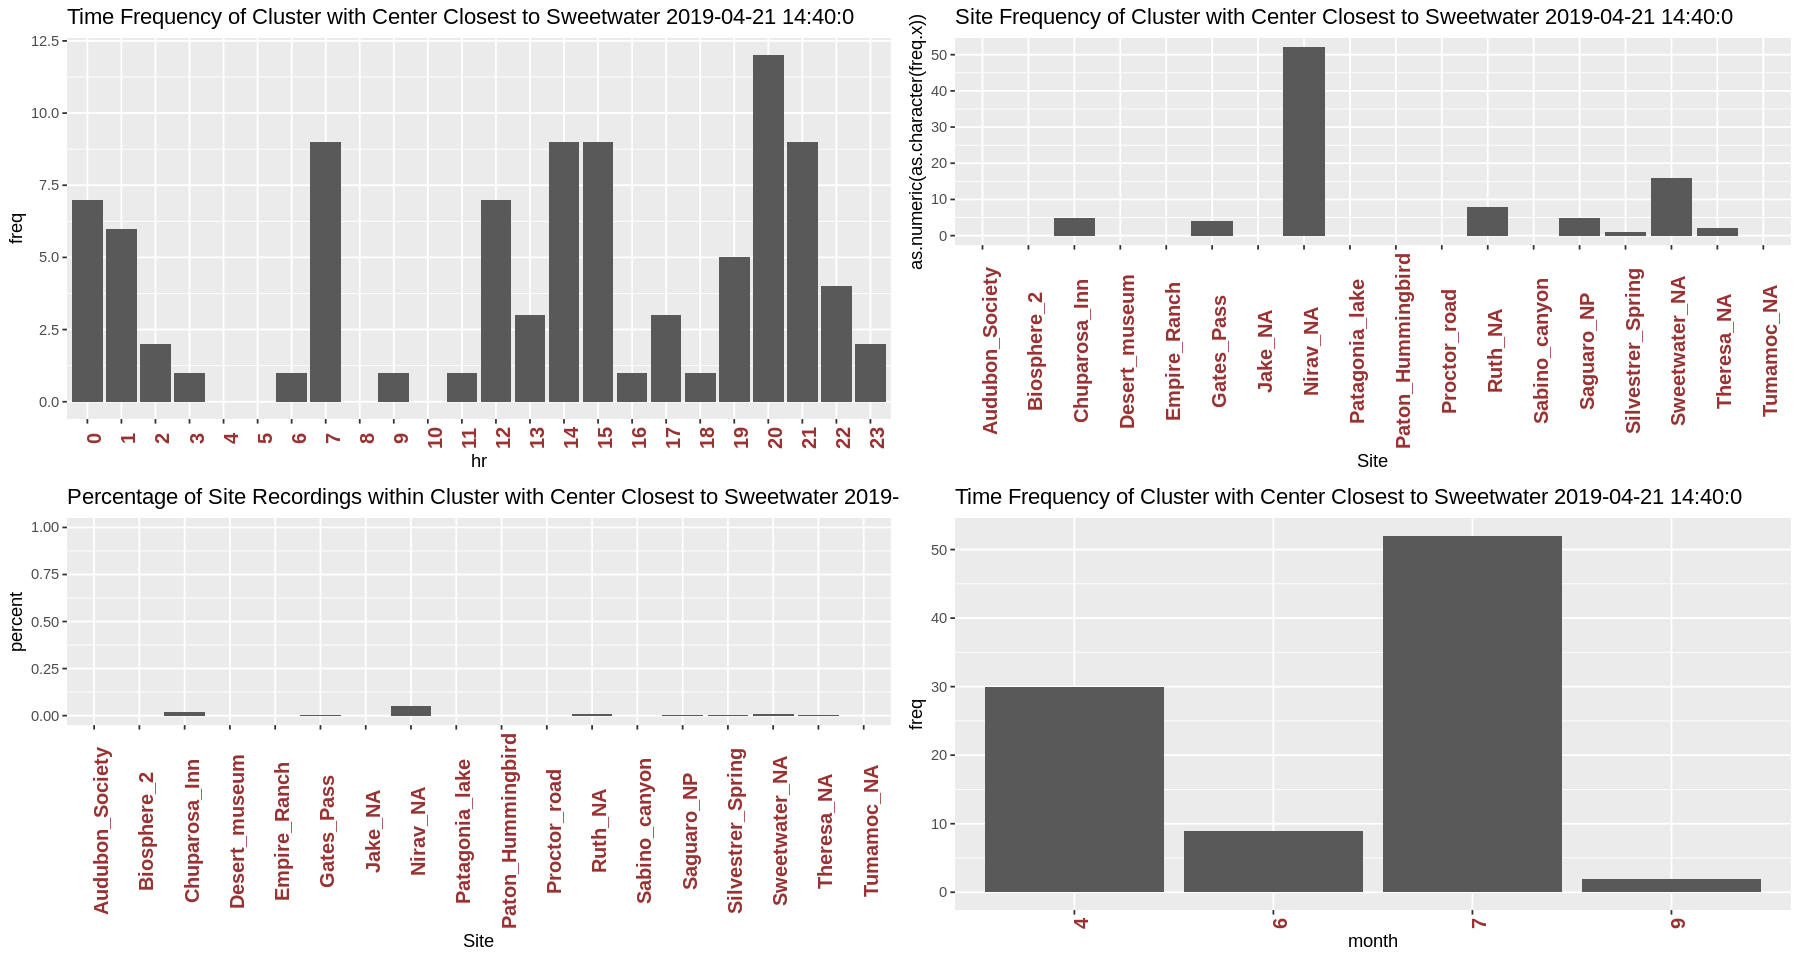

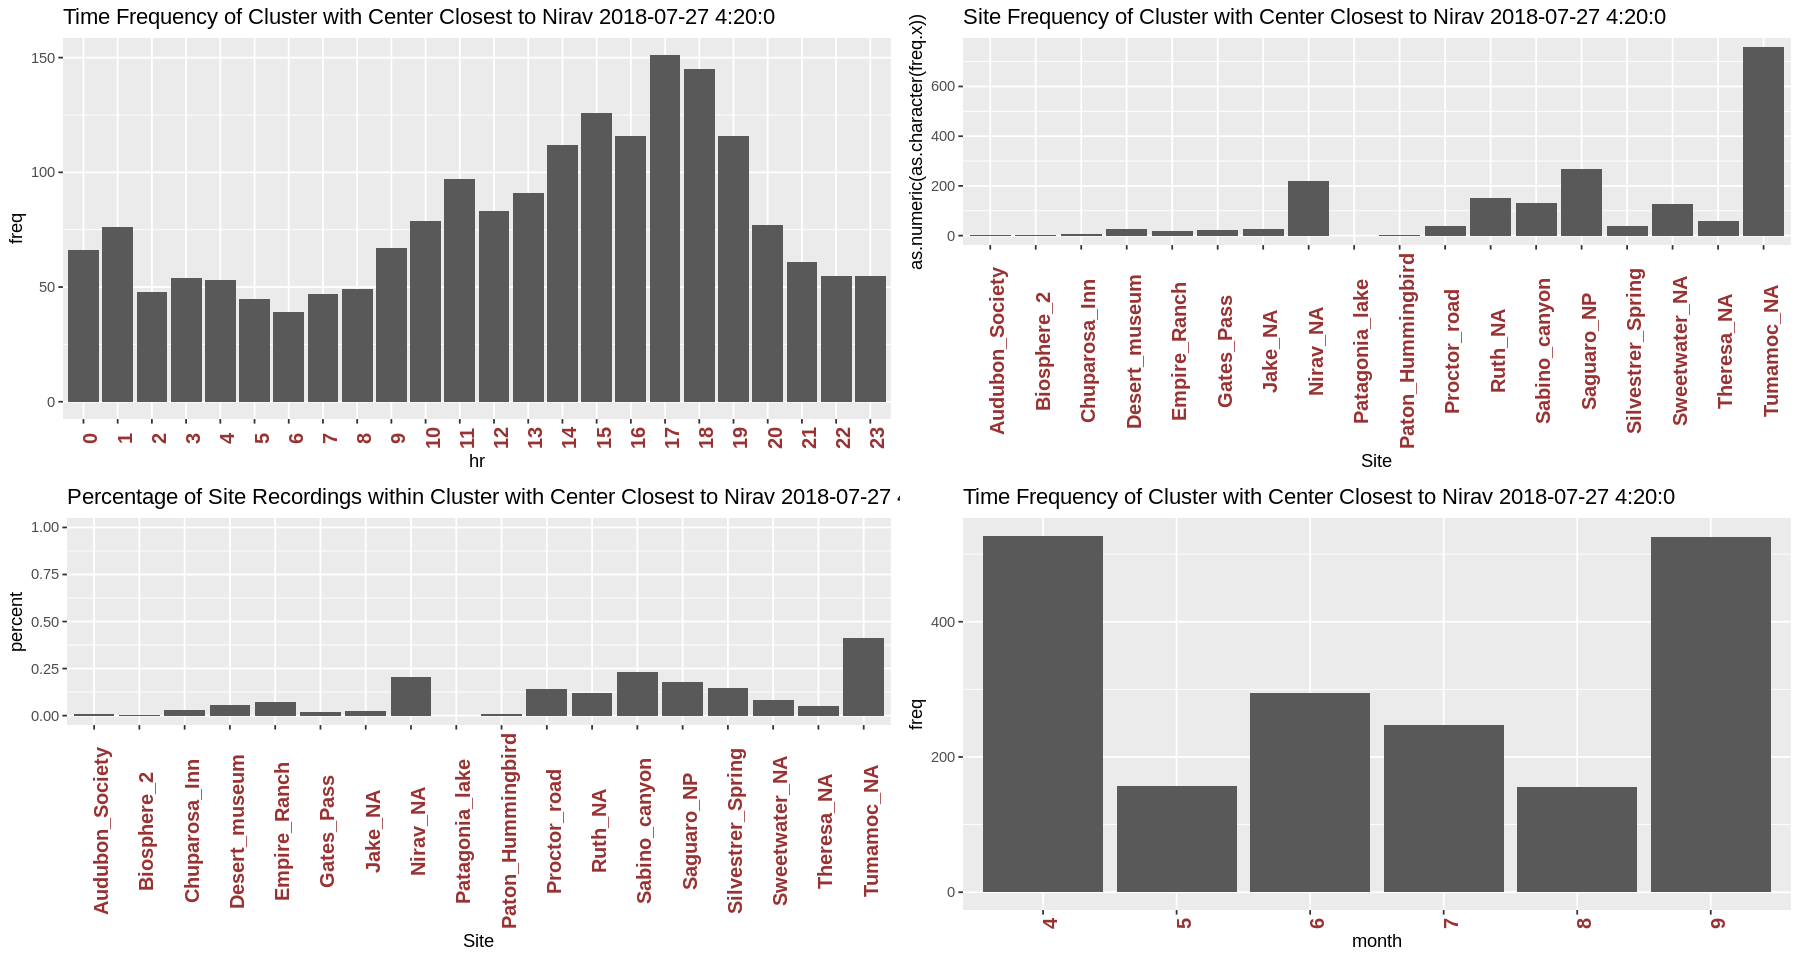

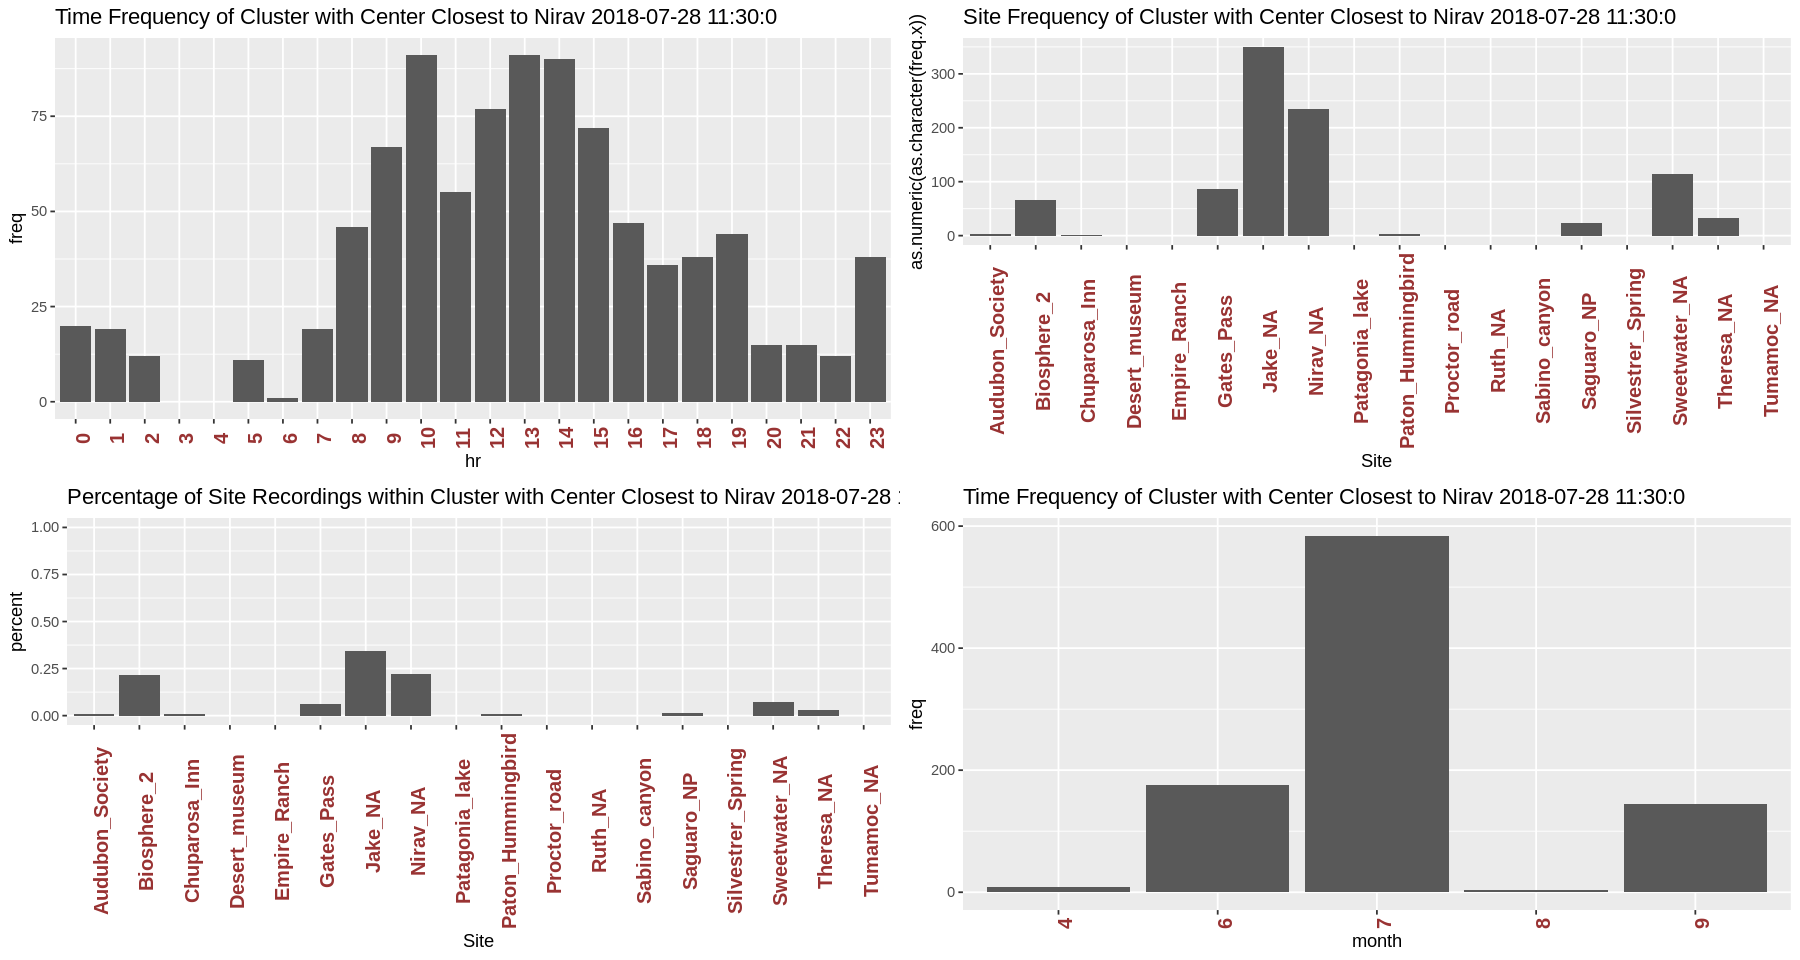

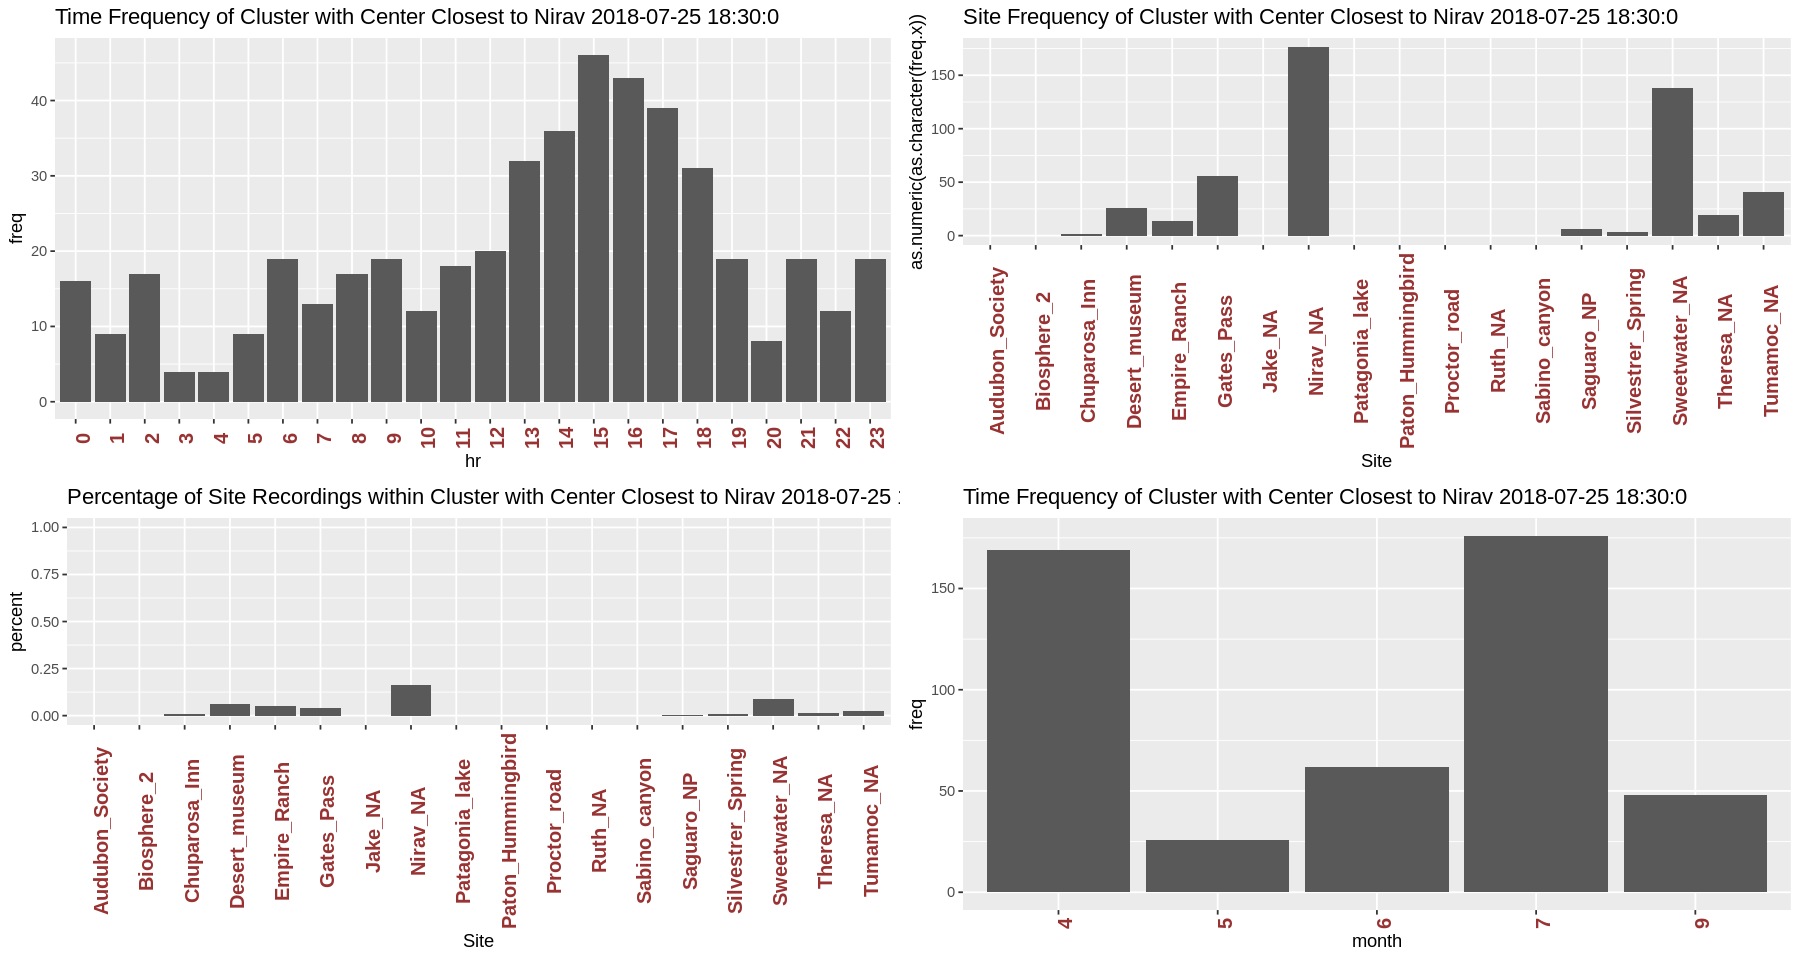

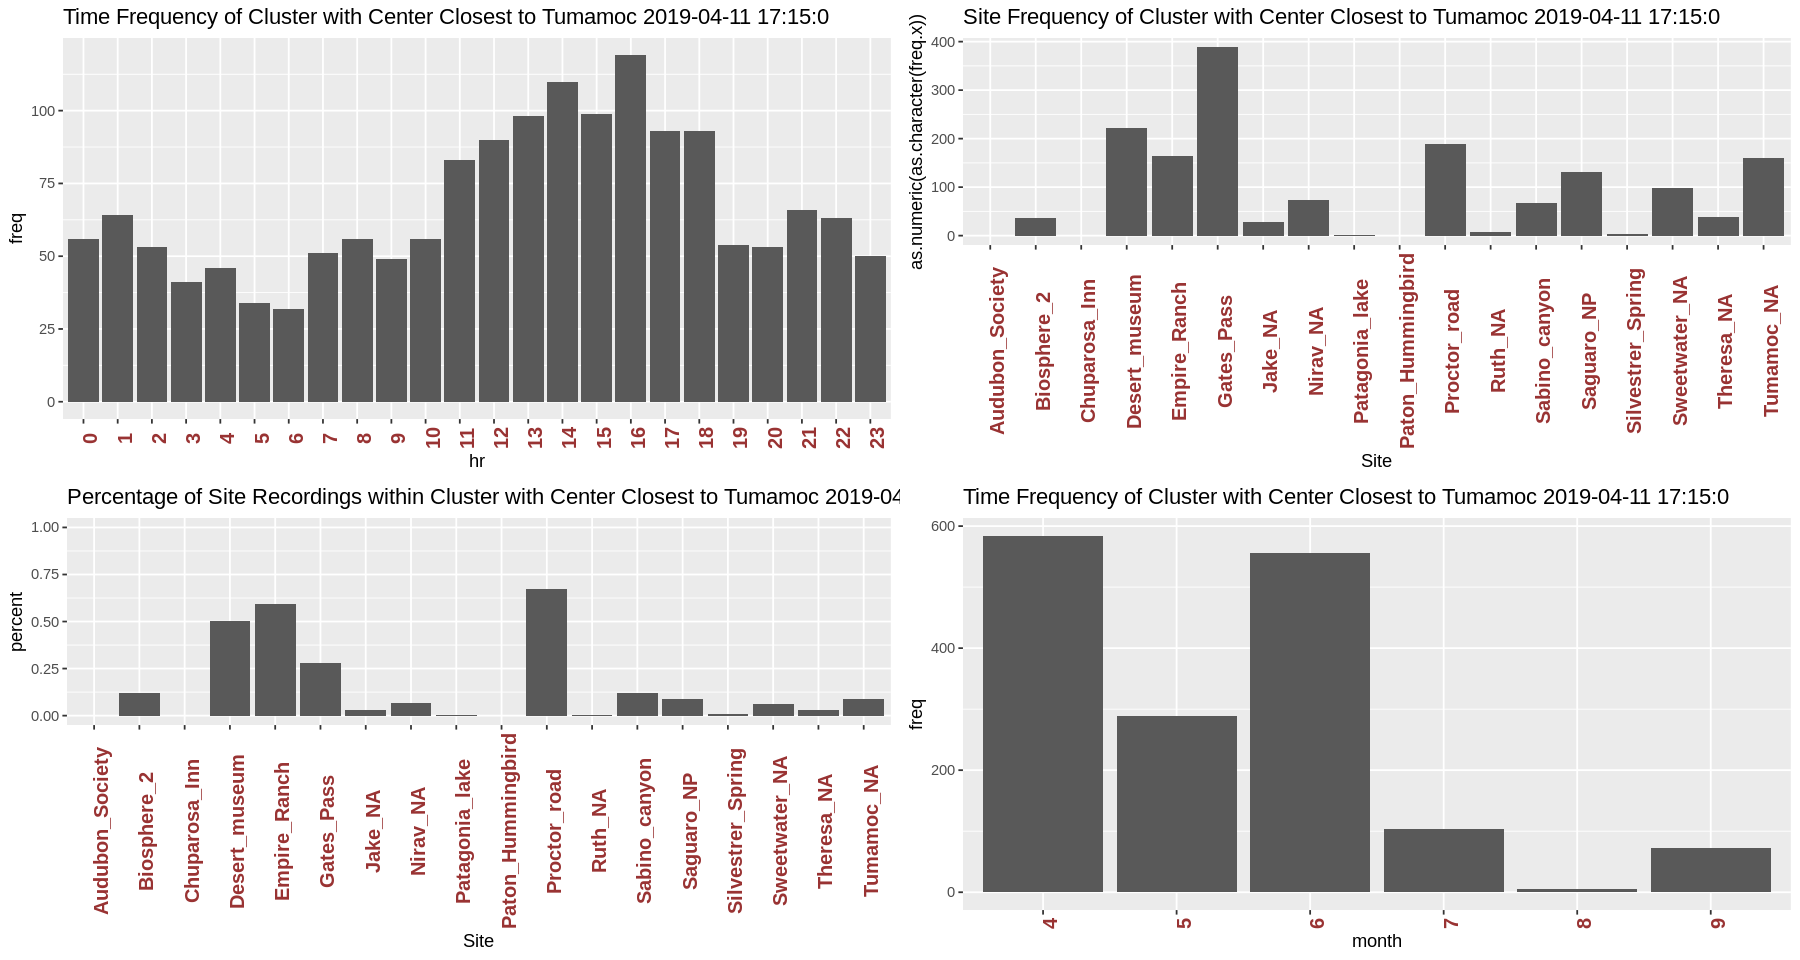

In [25]:
# K-Means Clustering with 10 clusters

fit <- kmeans(index_data[,7:16],10,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,7:16], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster))

A histogram indicating the frequency of the site of the recording in each cluster given below(a histogram for every cluster).

[1] 1740  362  758  436  524  728 1114 1690  837   93 1863  196 1465 1106 1181

bioacoustic....double.. amplitude....double.. temporal_entropy....double..
1  -0.13816394             -0.22943282            0.42754673                 
2  -0.58980452              0.32831528           -0.35453411                 
3  -0.14843930              0.09319790           -1.14235057                 
4  -0.04551355              2.71204985           -0.39465474                 
5  -0.74785705             -0.21845842           -0.92831690                 
6  -1.24466971              0.33380106           -0.05004592                 
7  -0.61715330             -0.04931754           -1.43241369                 
8   0.16751805              0.08451333           -1.12026011                 
9   1.11962152             -0.41145843            0.67755598                 
10 -1.04995436              8.25762575            0.61160649                 
11  0.88235451             -0.08620097            0.30986685                 
12 -1.26380672              0.65339123           -0.09316997                 
13  0.31849045             -0.41977516            0.68813576                 
14  0.99466576             -0.25743675            0.87446960                 
15 -1.28163534             -0.57620882            1.08035944                 
   spectral_entropy....double.. acoustic_entropy....double..
1  -0.30236955                  -0.28825995                 
2   1.34076013                   1.31874385                 
3  -0.04715854                  -0.09126036                 
4  -1.22465895                  -1.23203947                 
5   1.95839270                   1.89845966                 
6   1.62471335                   1.61634394                 
7  -1.41676370                  -1.44706529                 
8  -0.62020617                  -0.65447007                 
9   0.22045257                   0.24474571                 
10 -1.16088170                  -1.14270834                 
11  0.25676230                   0.26682926                 
12  2.19029702                   2.17588421                 
13  0.35904874                   0.38431868                 
14  0.80116230                   0.83689585                 
15 -1.15867543                  -1.12926731                 
   acoustic_diversity....double.. acoustic_evenness....double..
1  -0.694318639                    0.6271091                   
2   1.411420223                   -1.3543420                   
3   0.009559736                    0.1882581                   
4  -0.821694369                    0.6480514                   
5   2.079722158                   -2.9334951                   
6   1.309023335                   -1.1861727                   
7  -0.932378753                    0.7100067                   
8  -0.917445097                    0.7126493                   
9   0.795517254                   -0.5293950                   
10 -0.513993231                    0.4598252                   
11 -0.288828719                    0.4185108                   
12  1.861471383                   -2.5103828                   
13  0.432585489                   -0.0650566                   
14  1.244355947                   -1.0330986                   
15 -0.728366602                    0.6179649                   
   acoustic_complexity....double.. nrows....double.. ndsi....double..
1  -0.4740469                      -0.19746100       -1.22898524     
2   2.7788897                       0.02742841        0.75794213     
3  -0.1693729                       0.01758072        0.94633009     
4   0.8920719                      -0.30307215       -0.28732937     
5   1.1570269                       0.06338518        1.16757953     
6  -0.7940715                       0.27934030        1.13788717     
7   0.6167879                      -0.31585258       -0.05536385     
8  -0.0170561                      -0.29249079       -0.92247167     
9   1.3633099                      -0.13401954        0.83788955     
10  2.7088533                      -0.27183245       -0

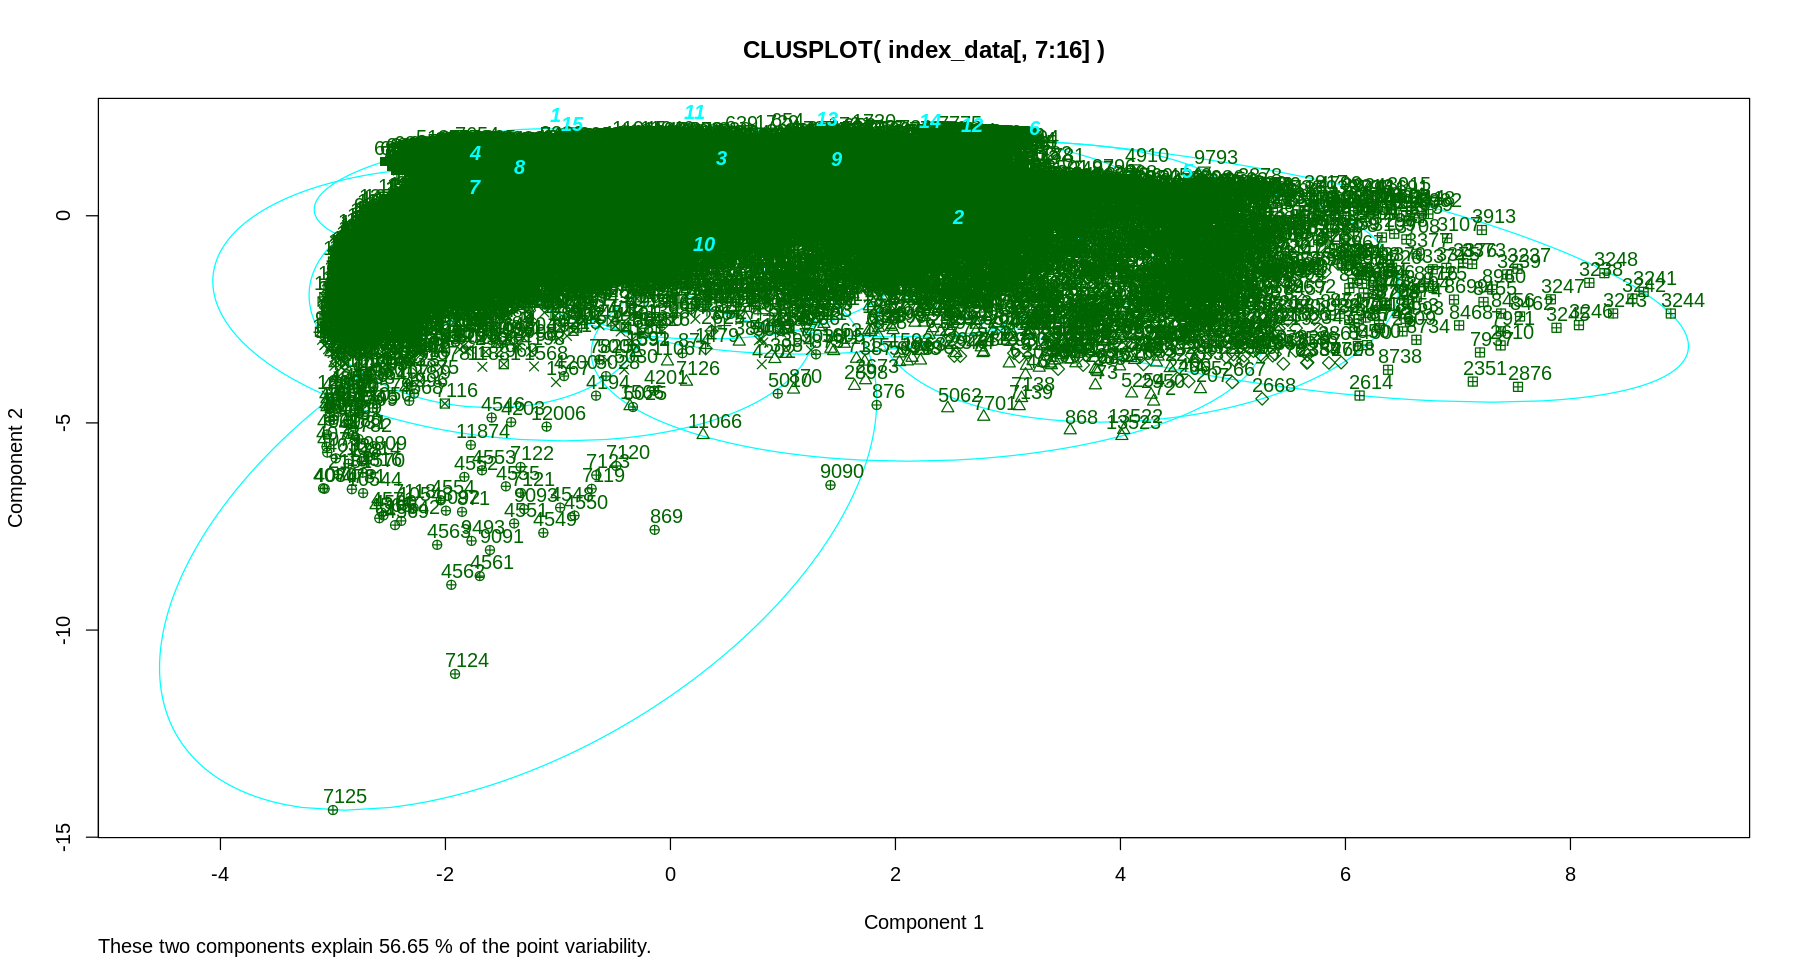

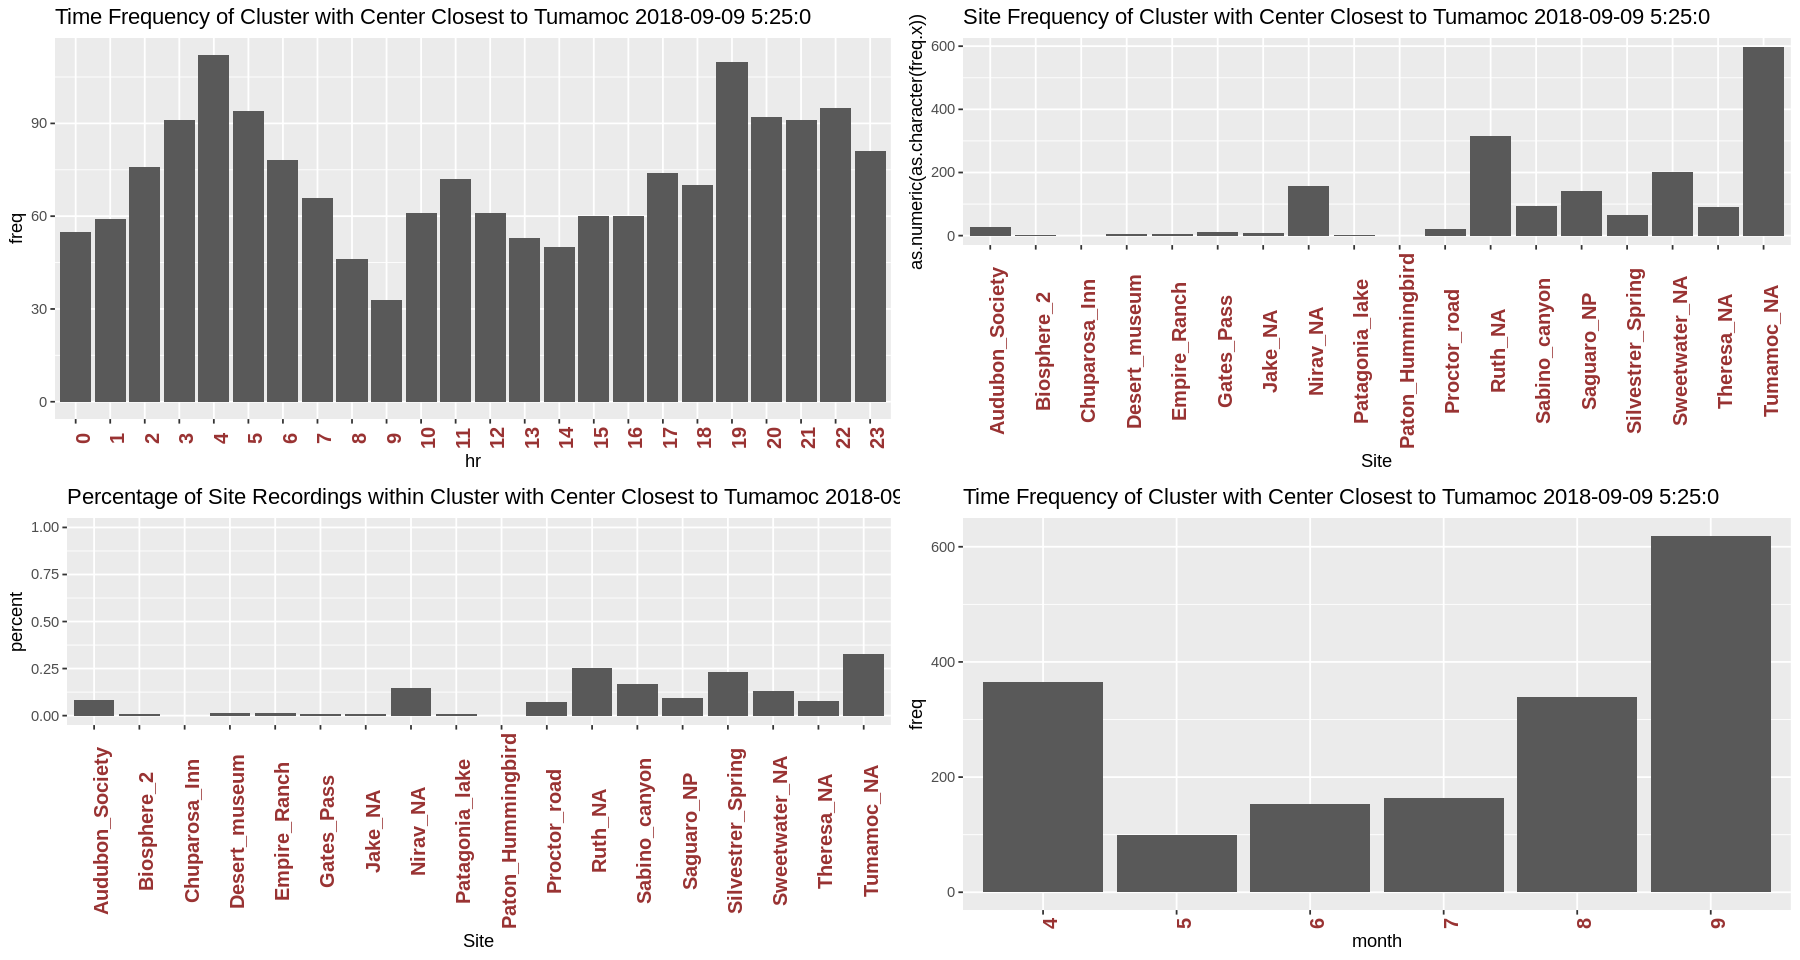

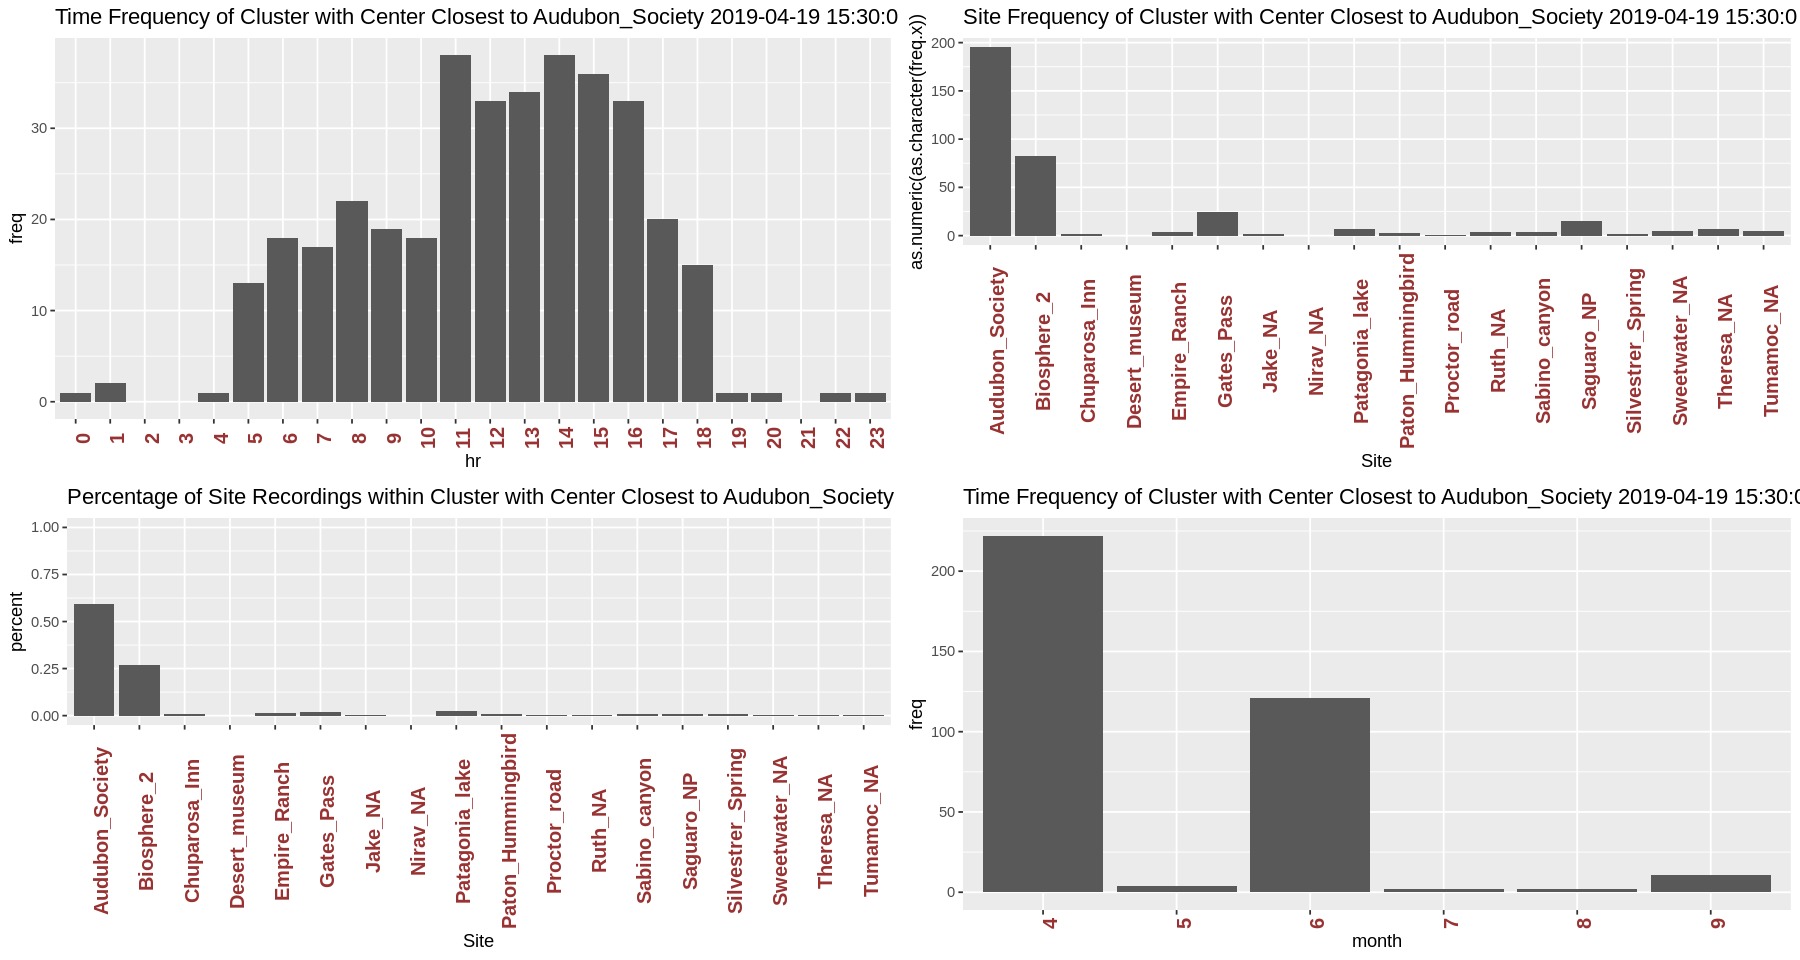

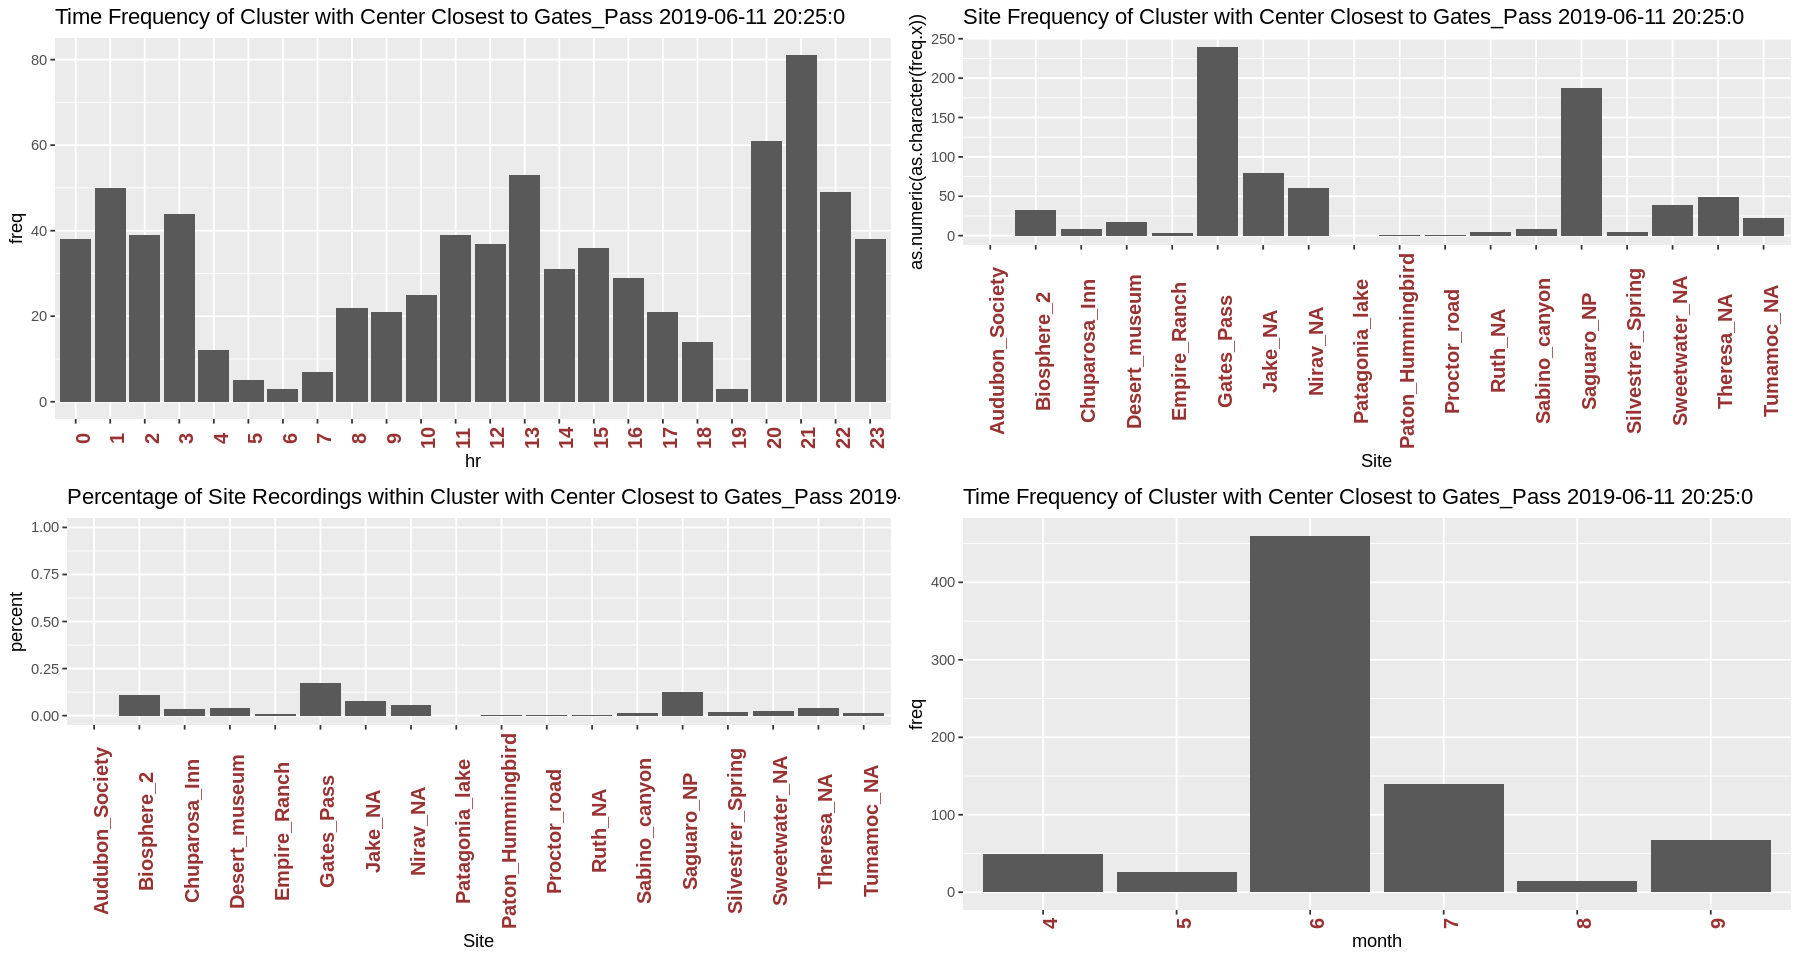

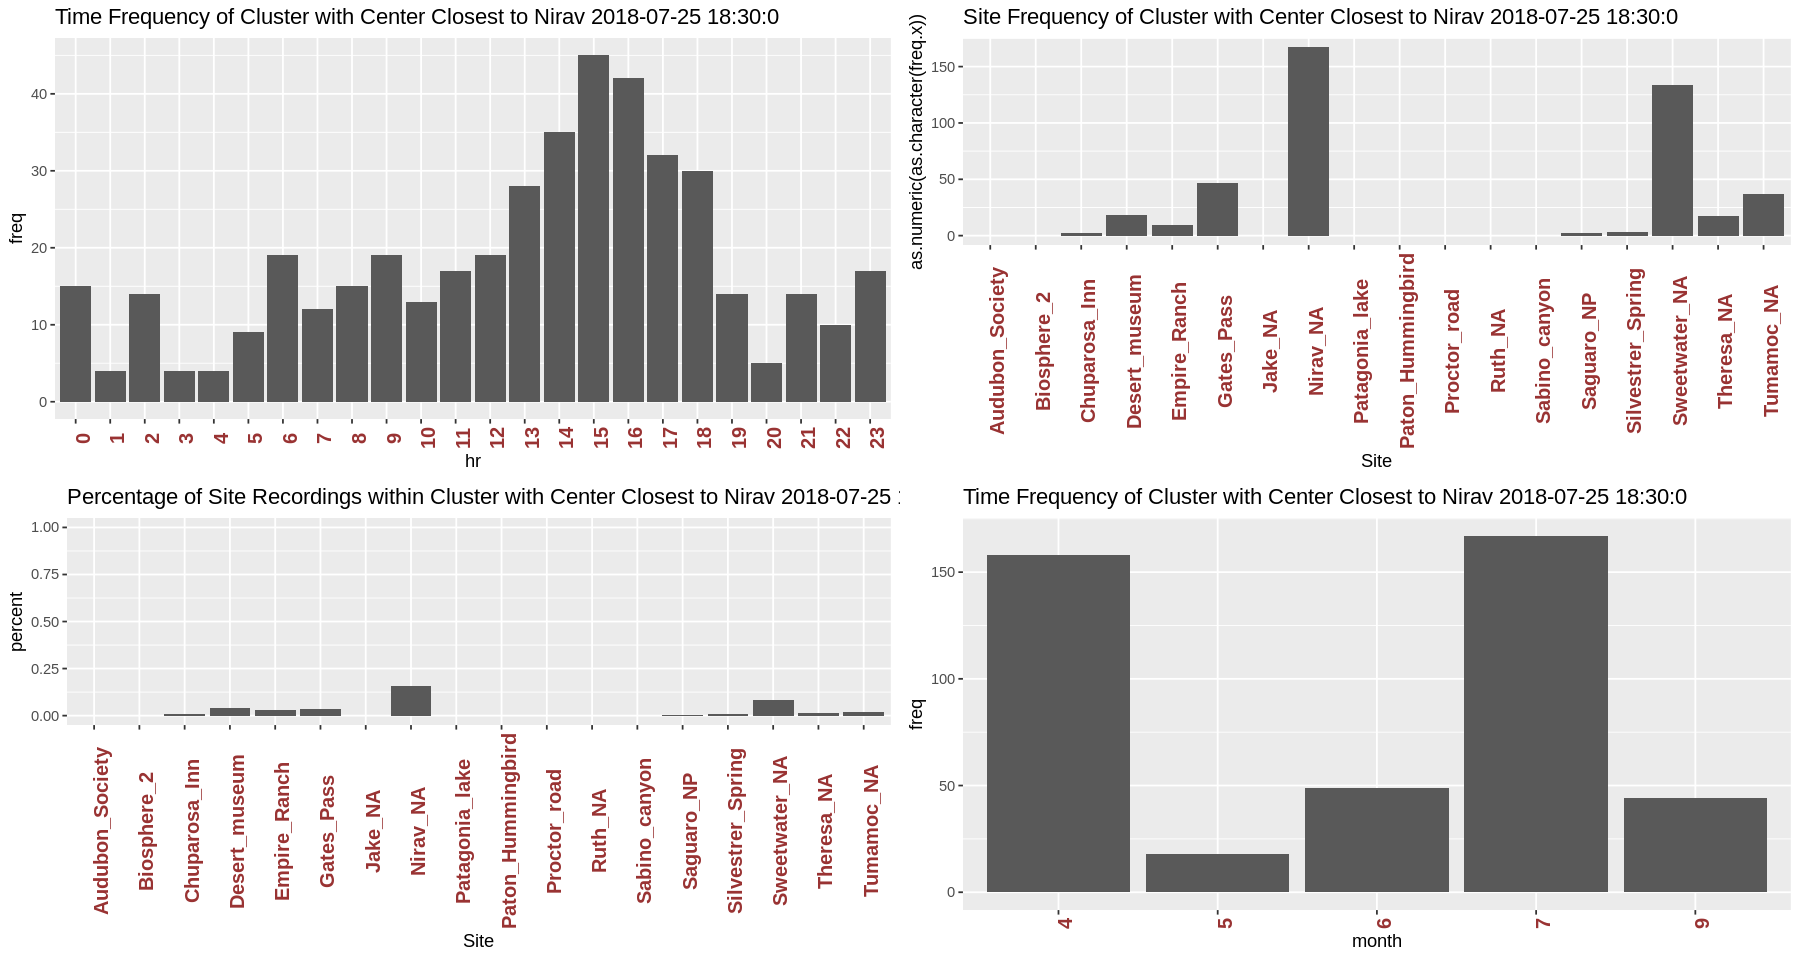

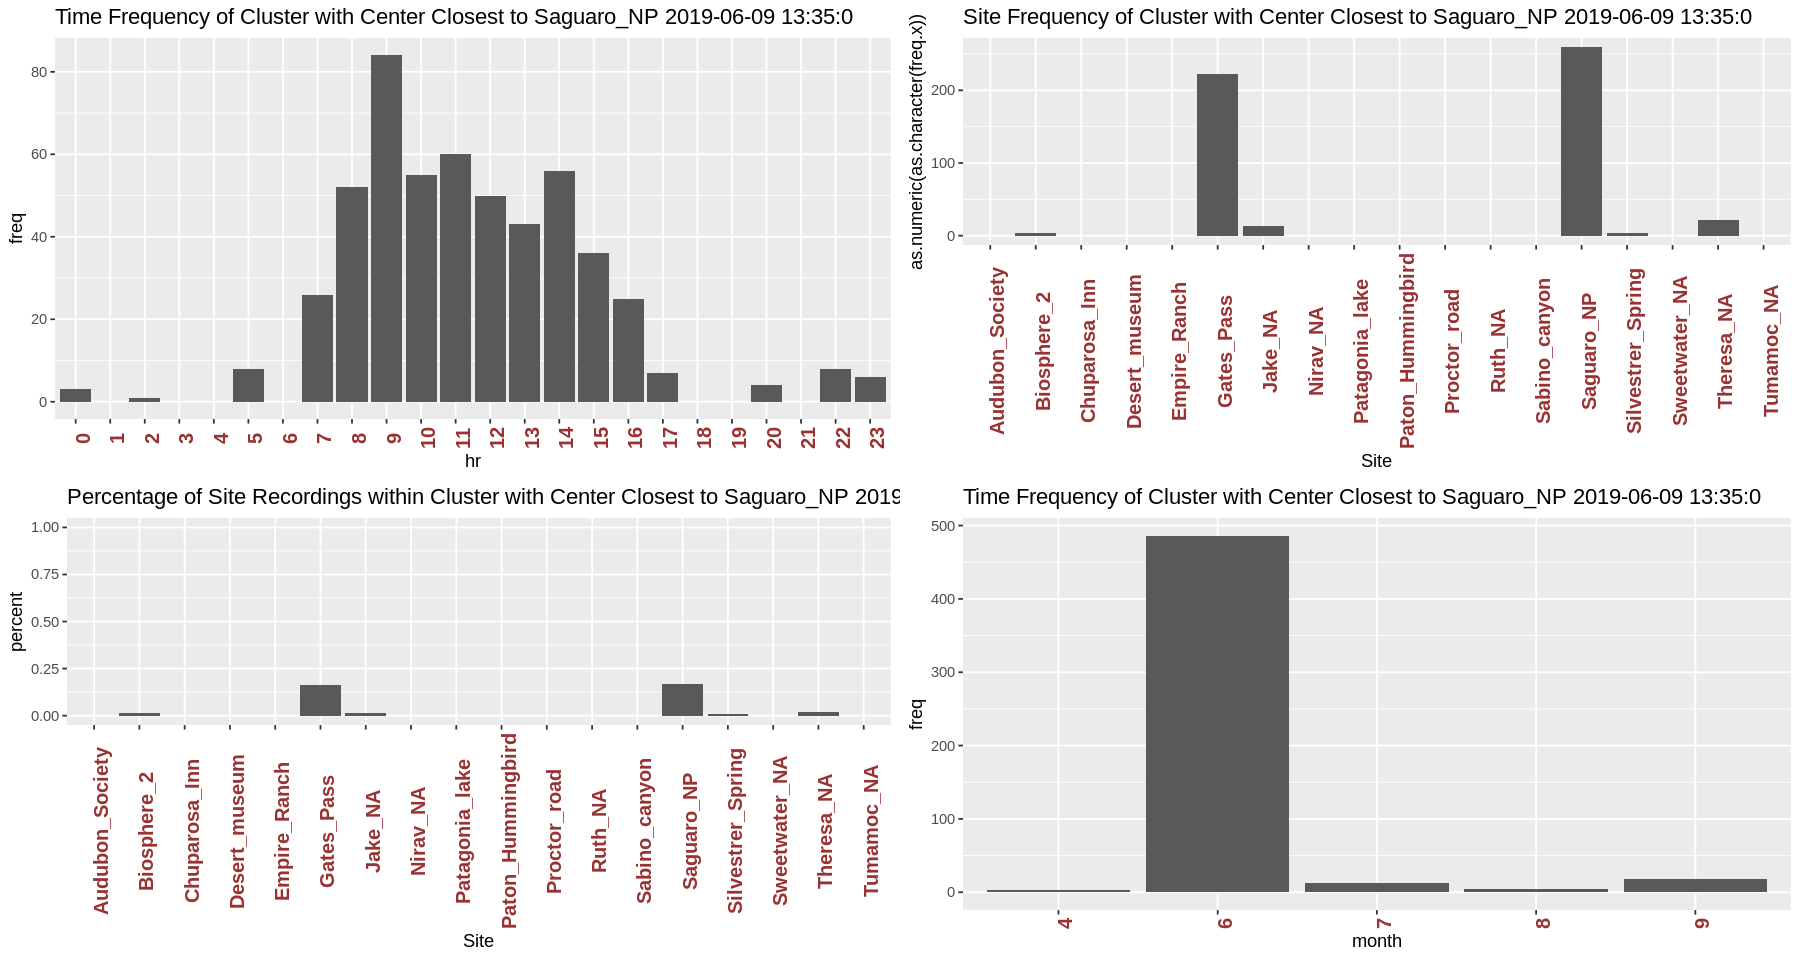

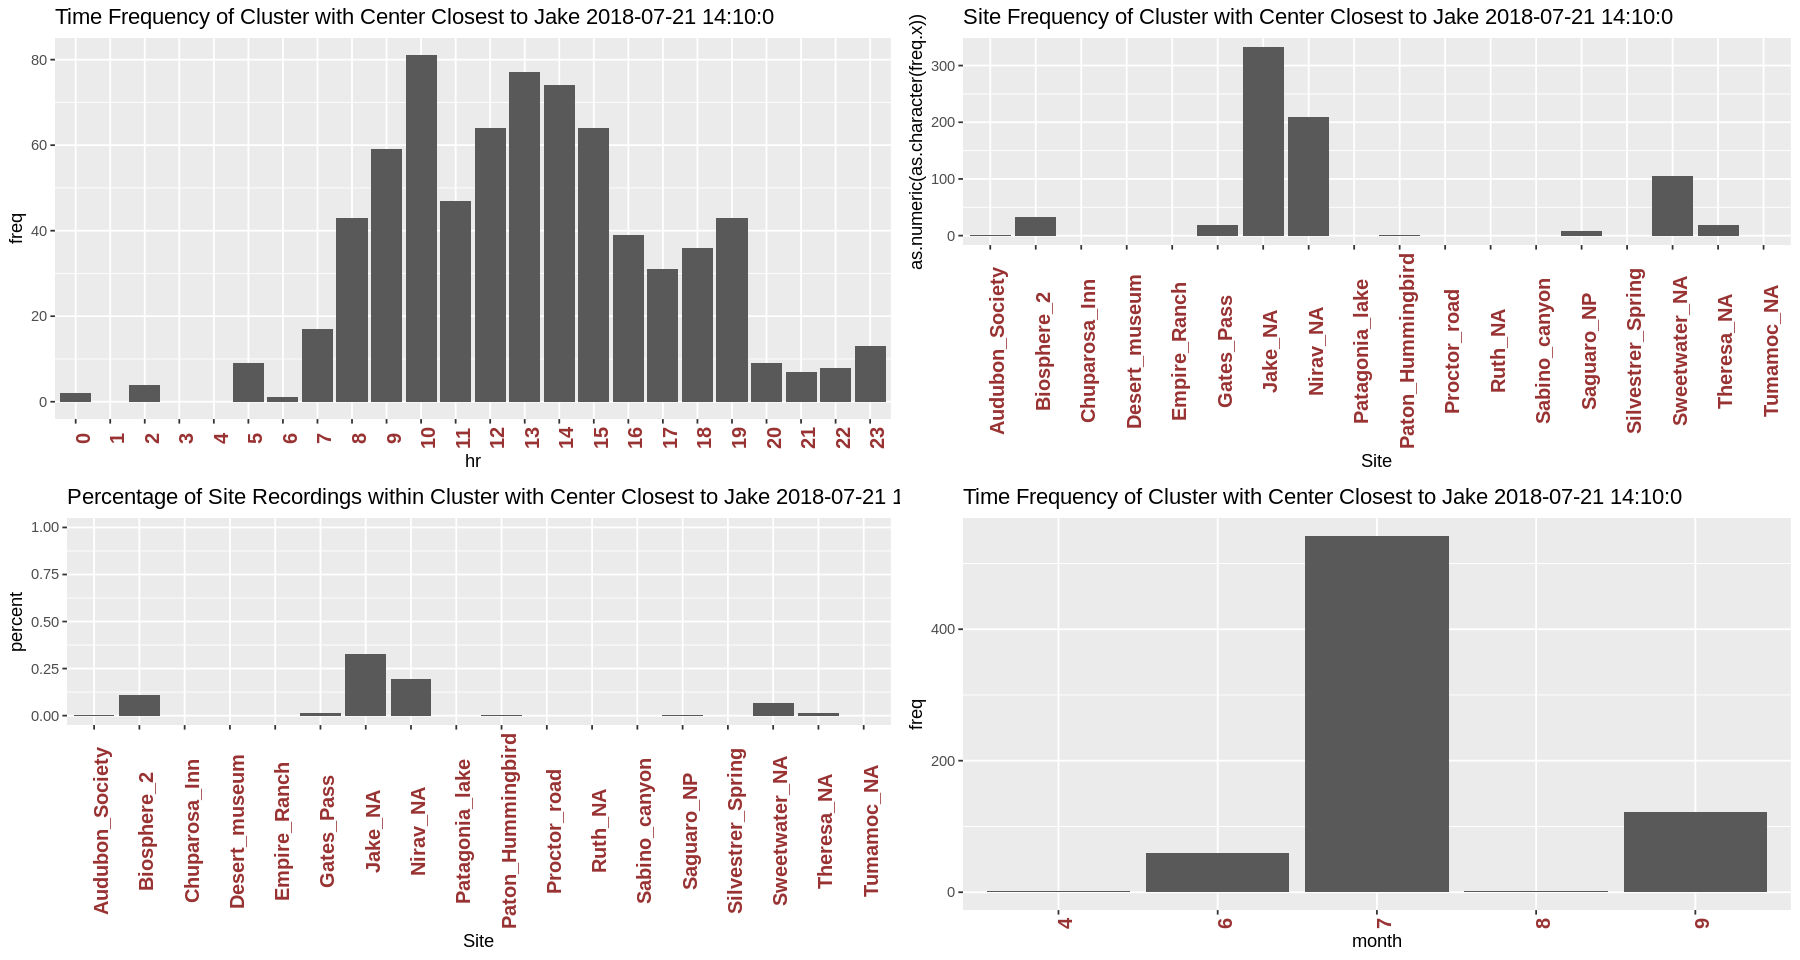

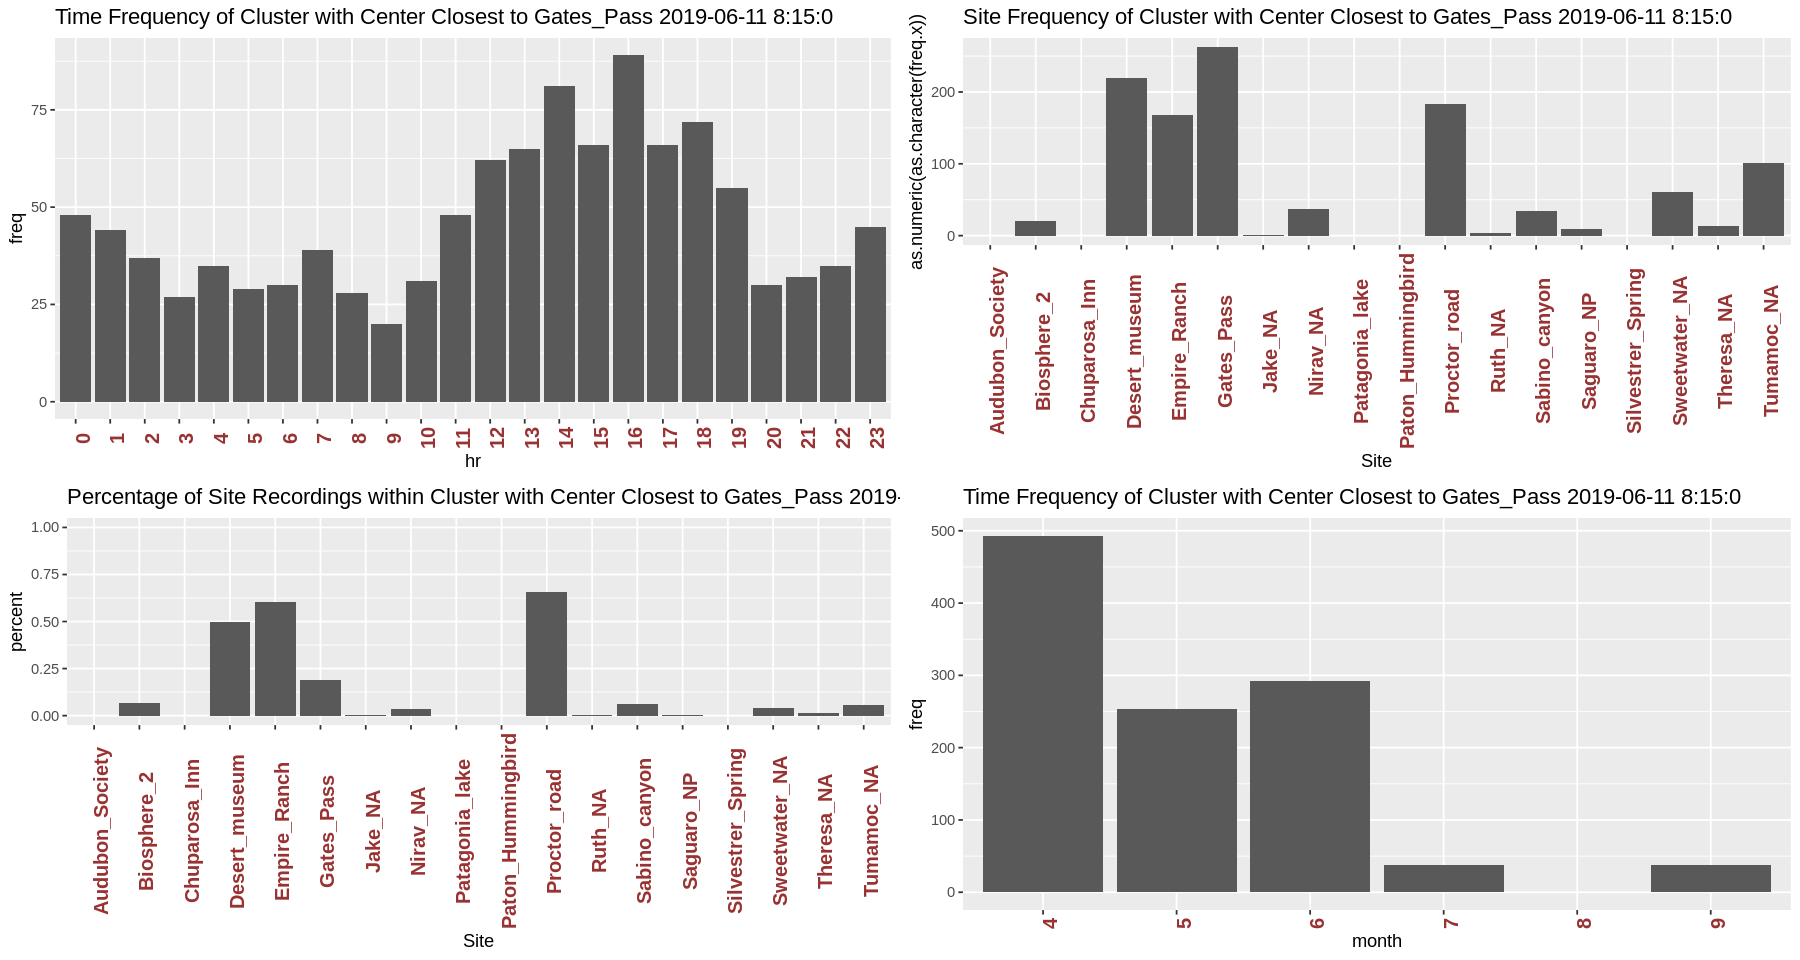

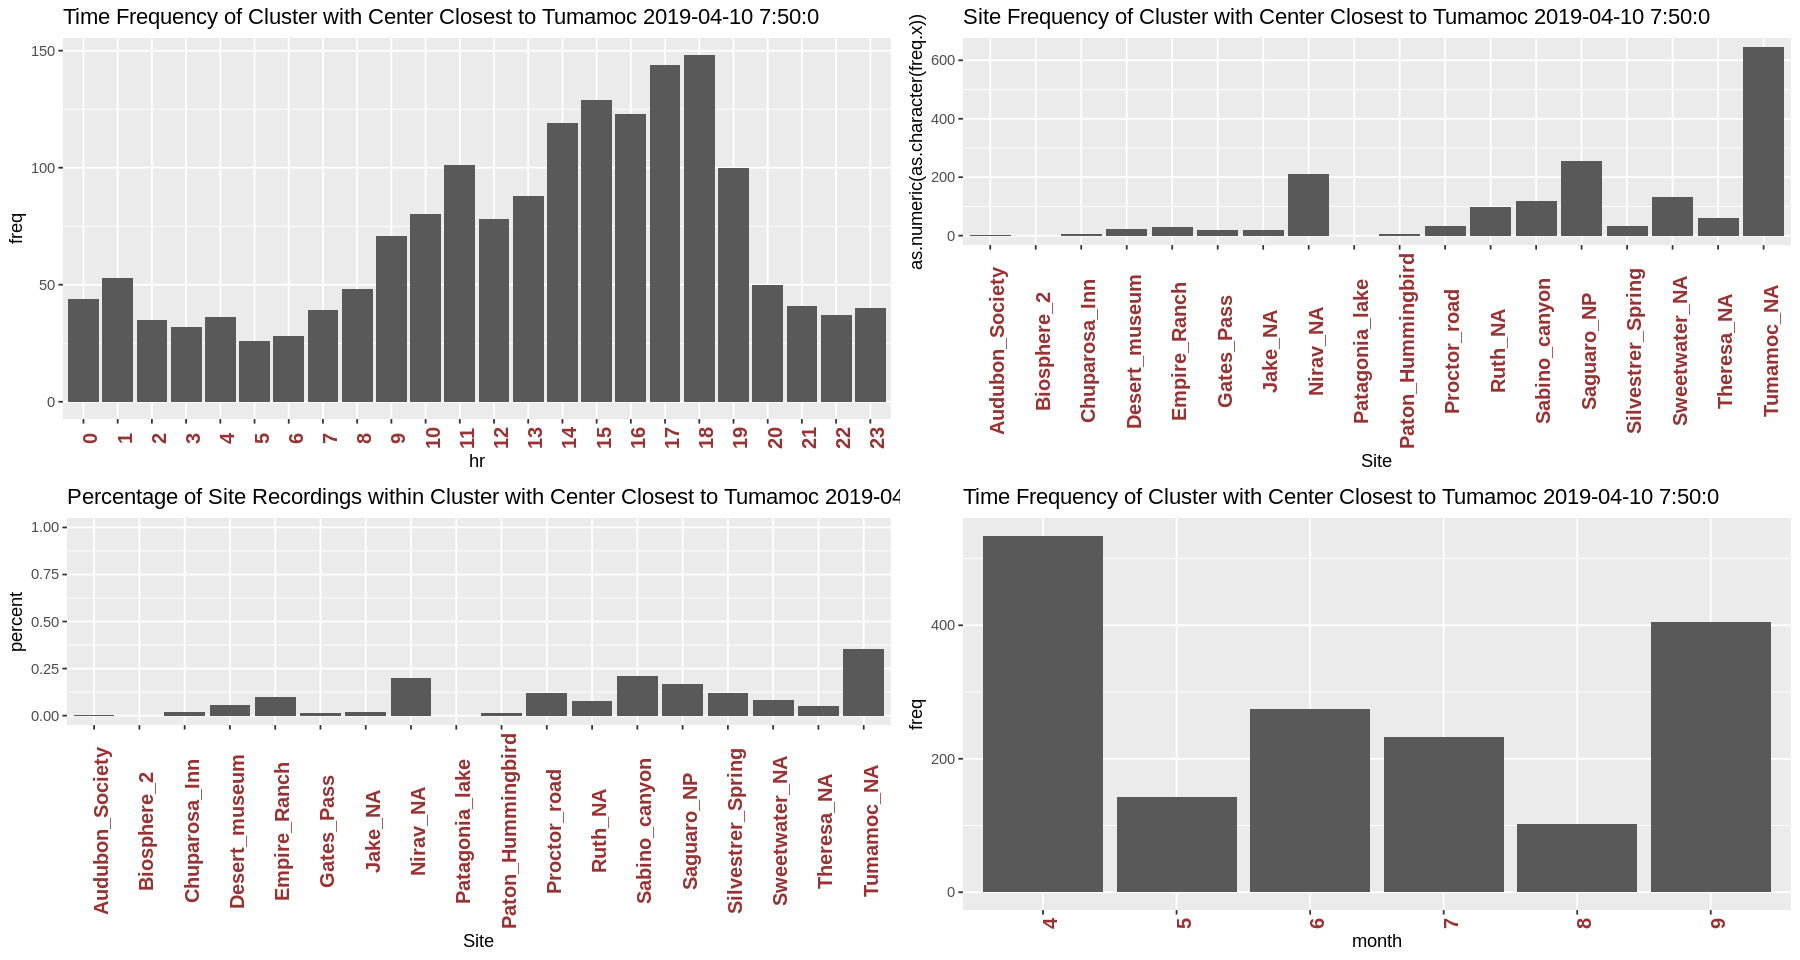

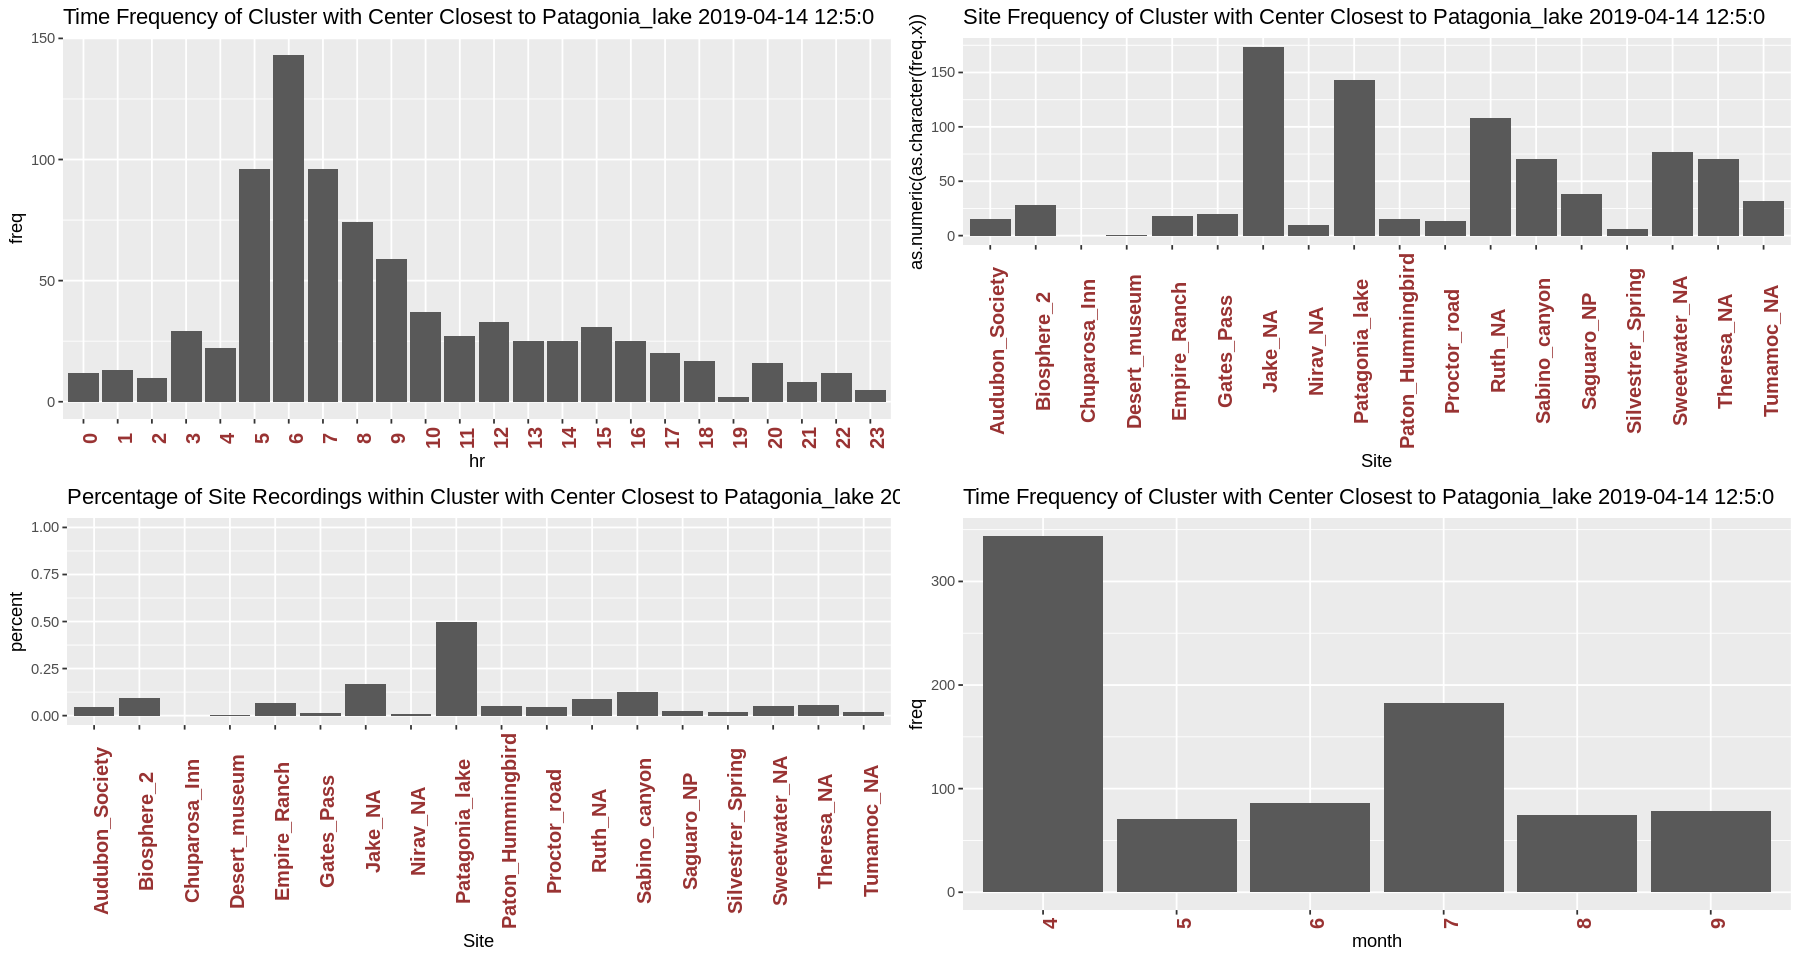

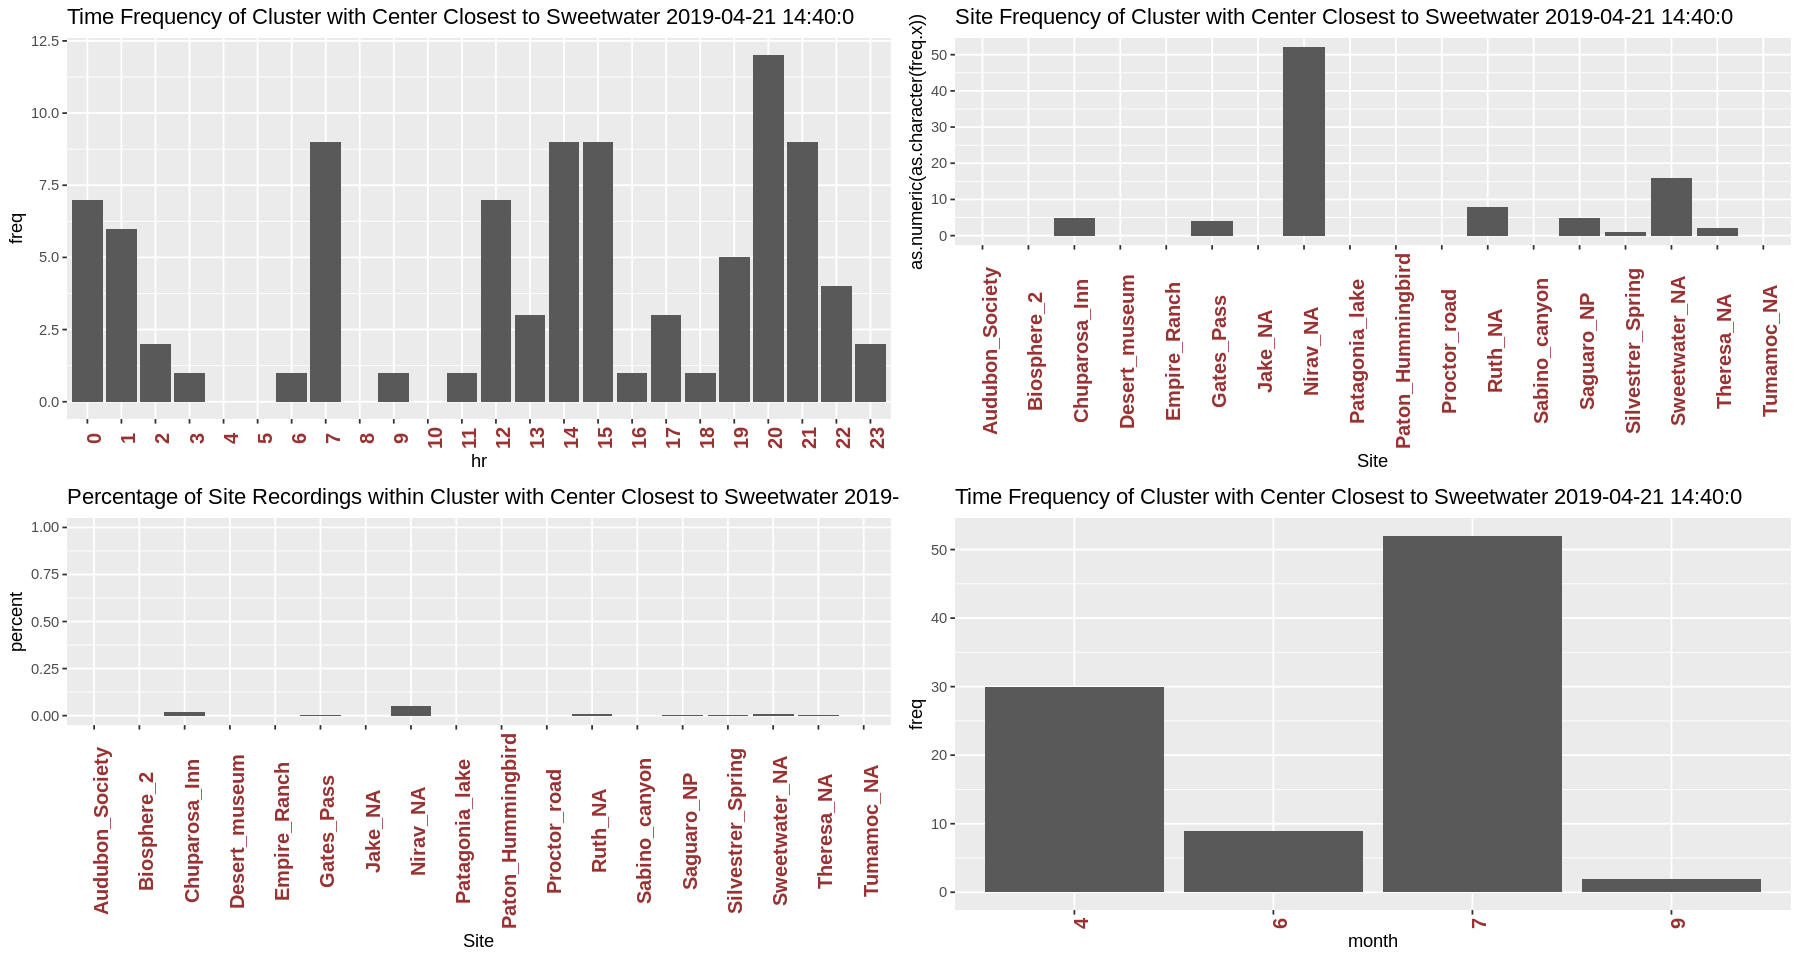

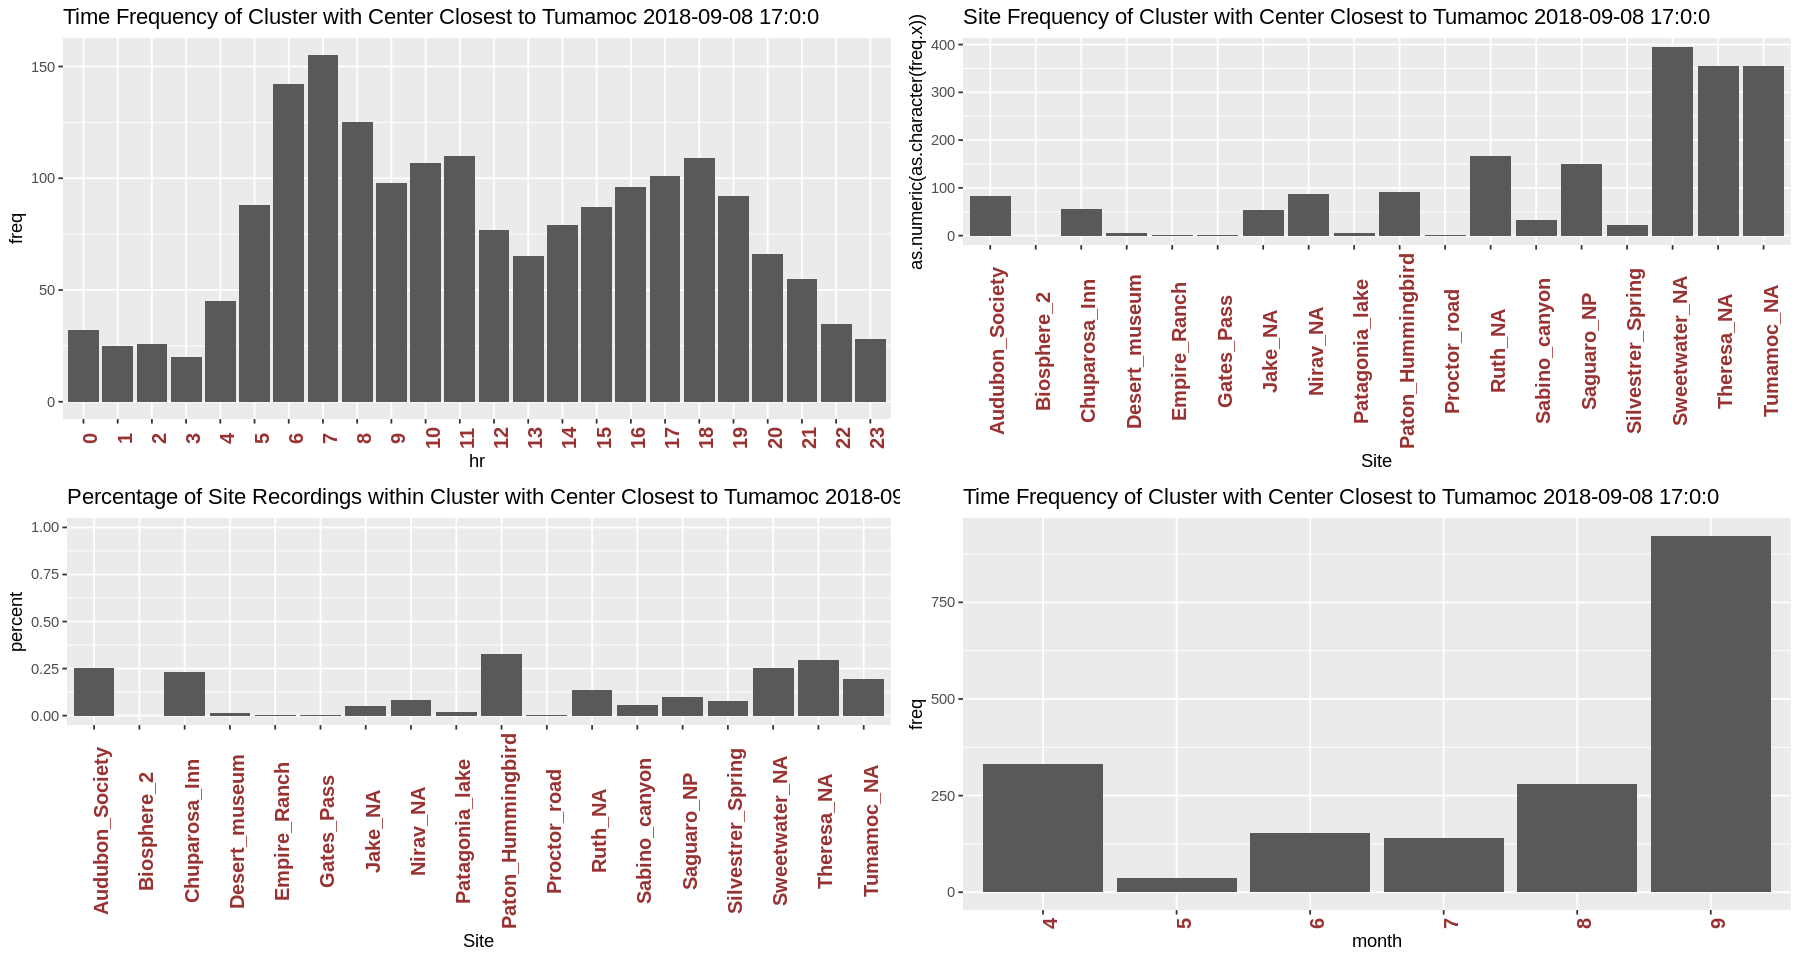

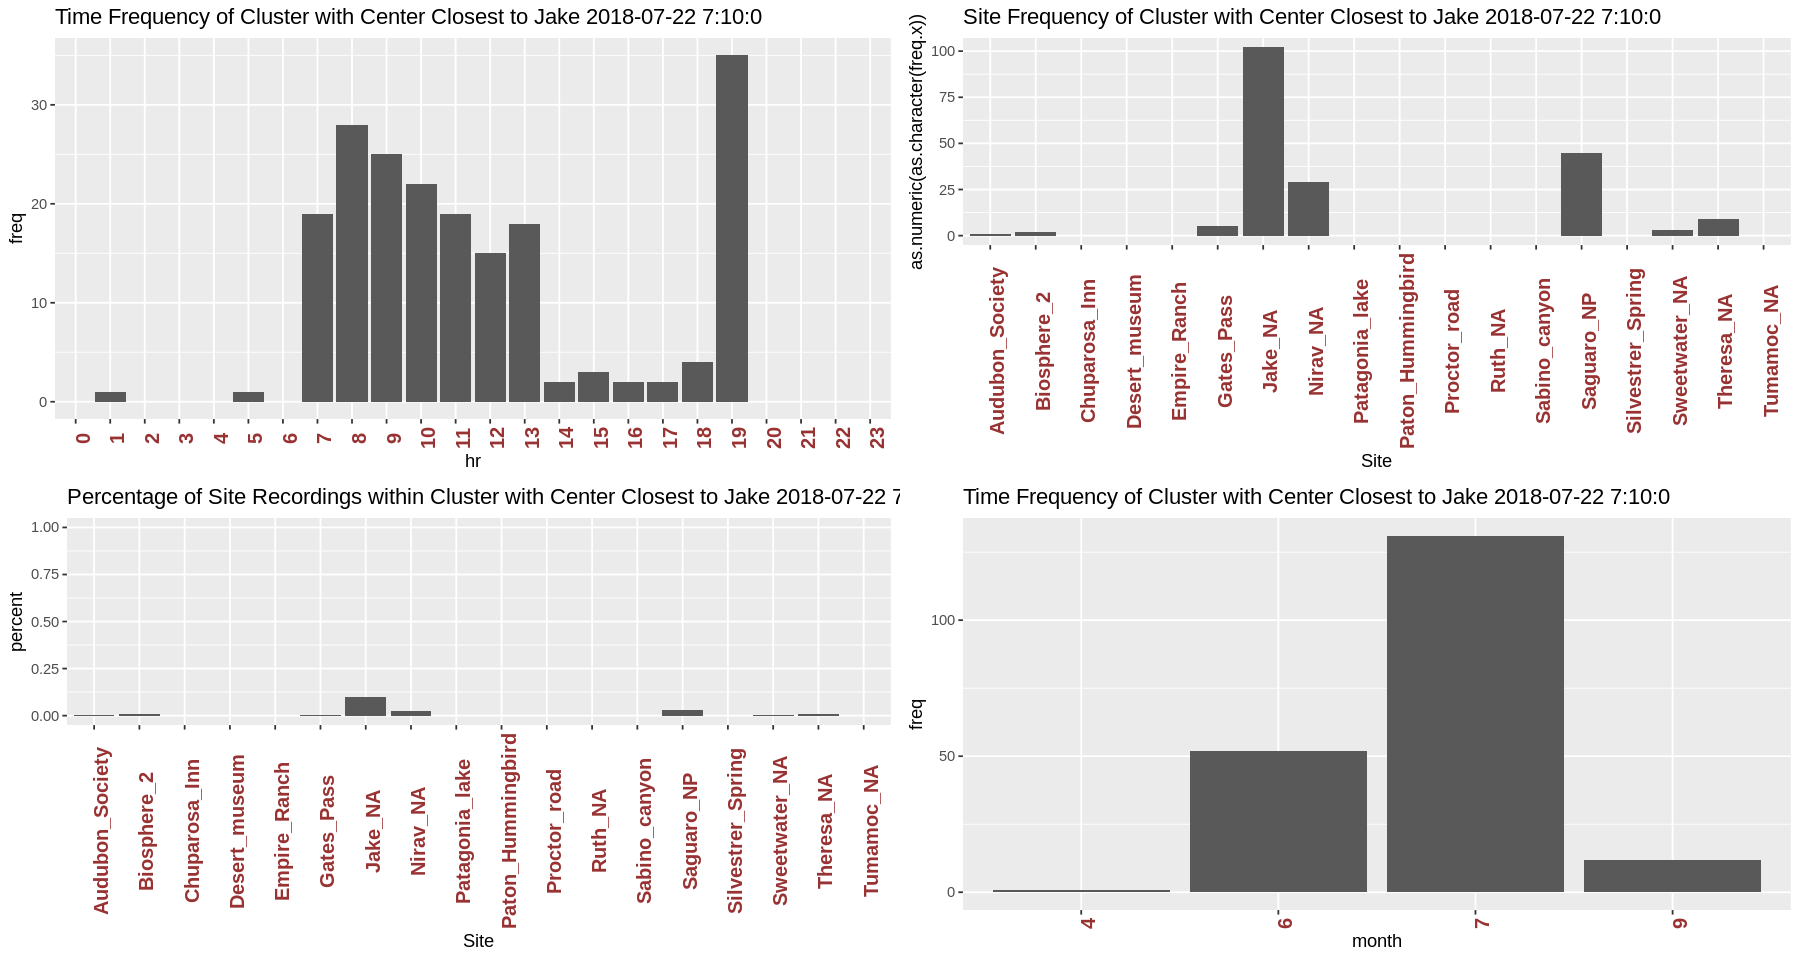

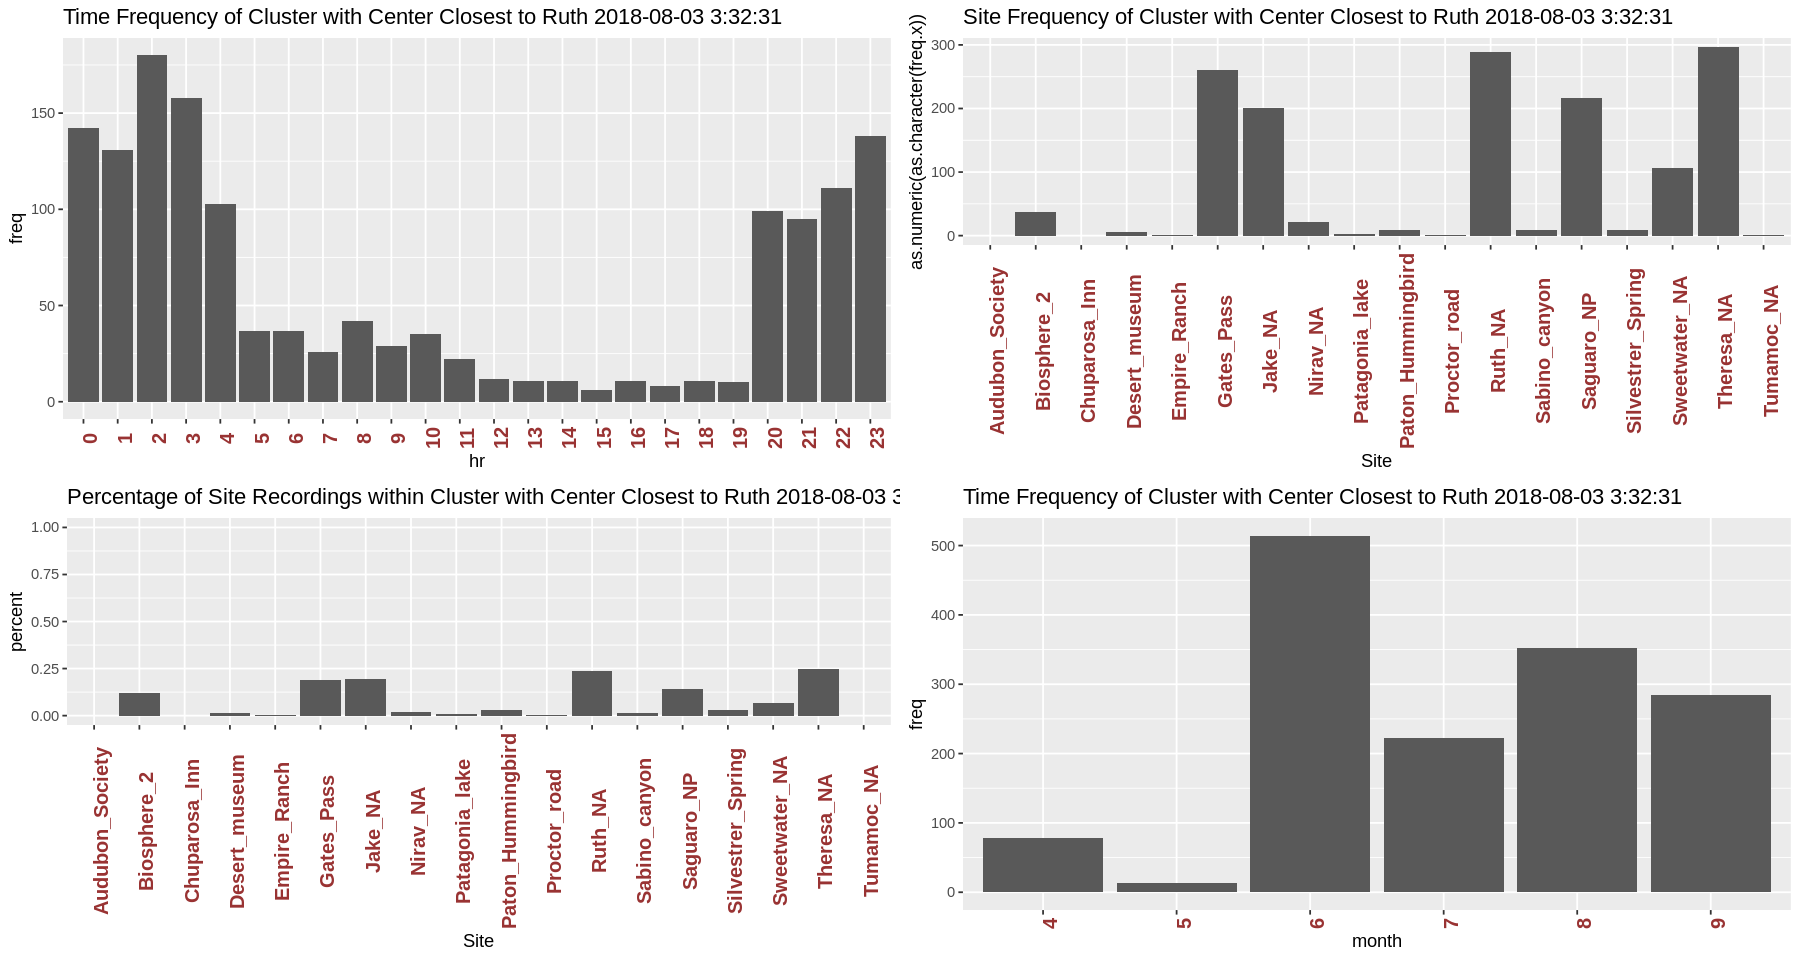

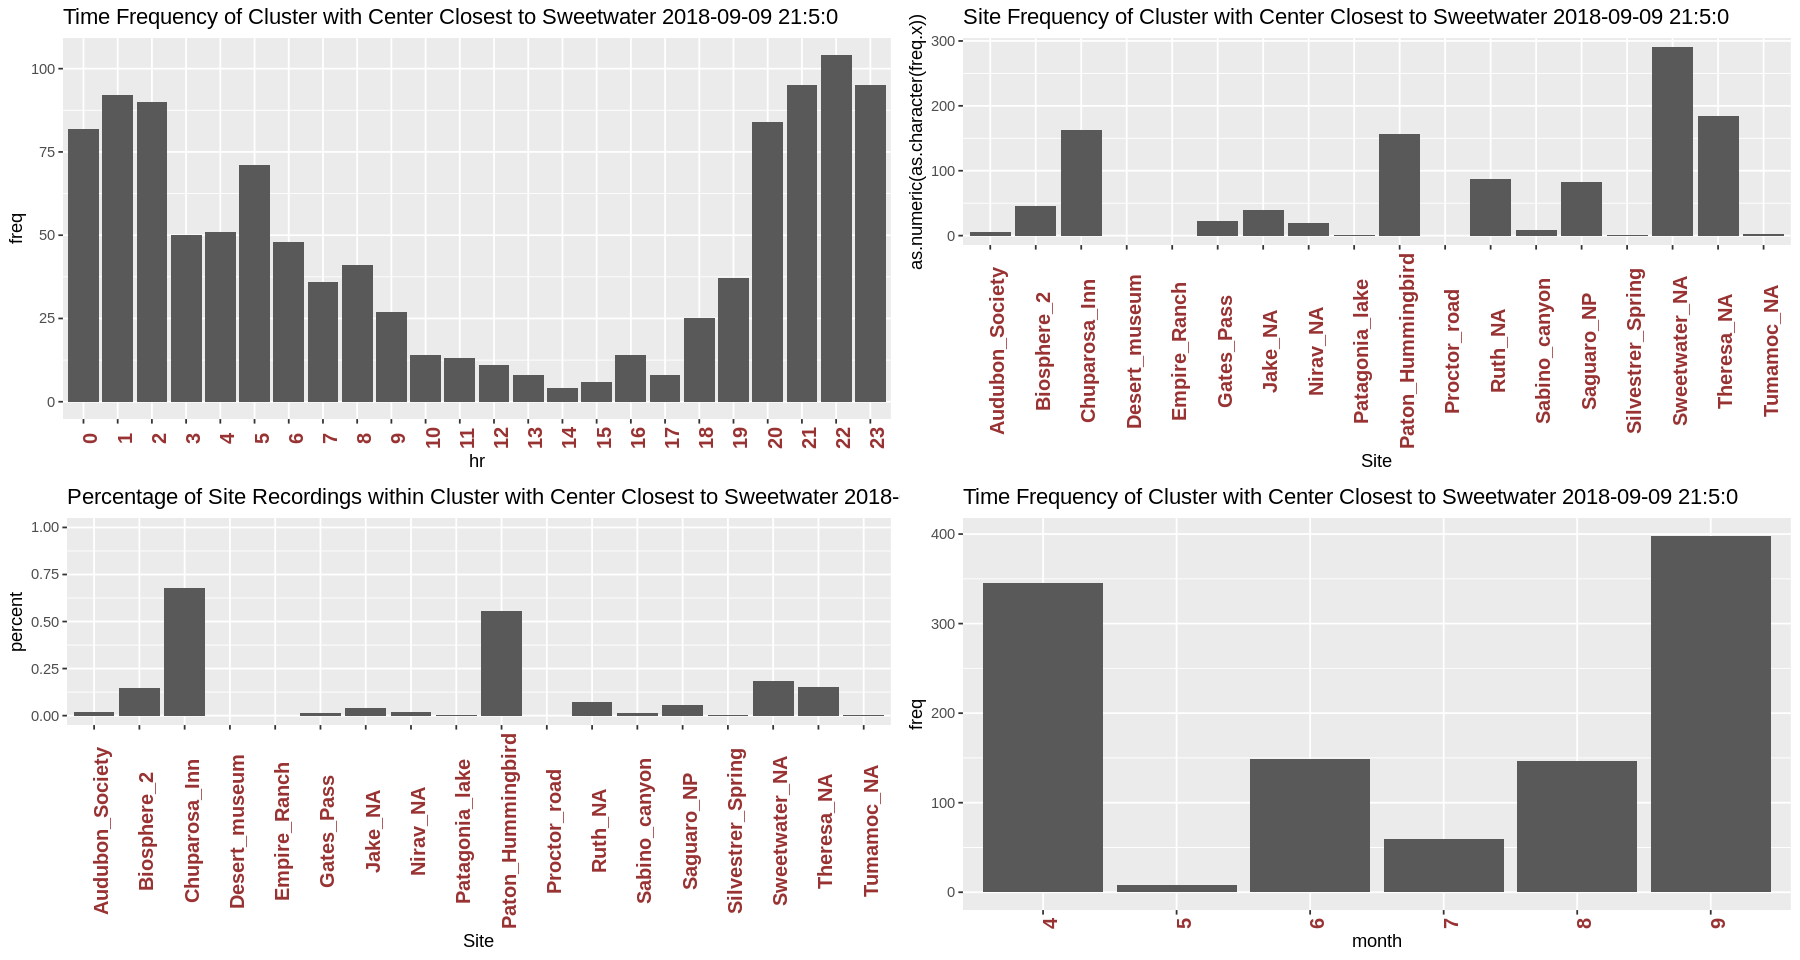

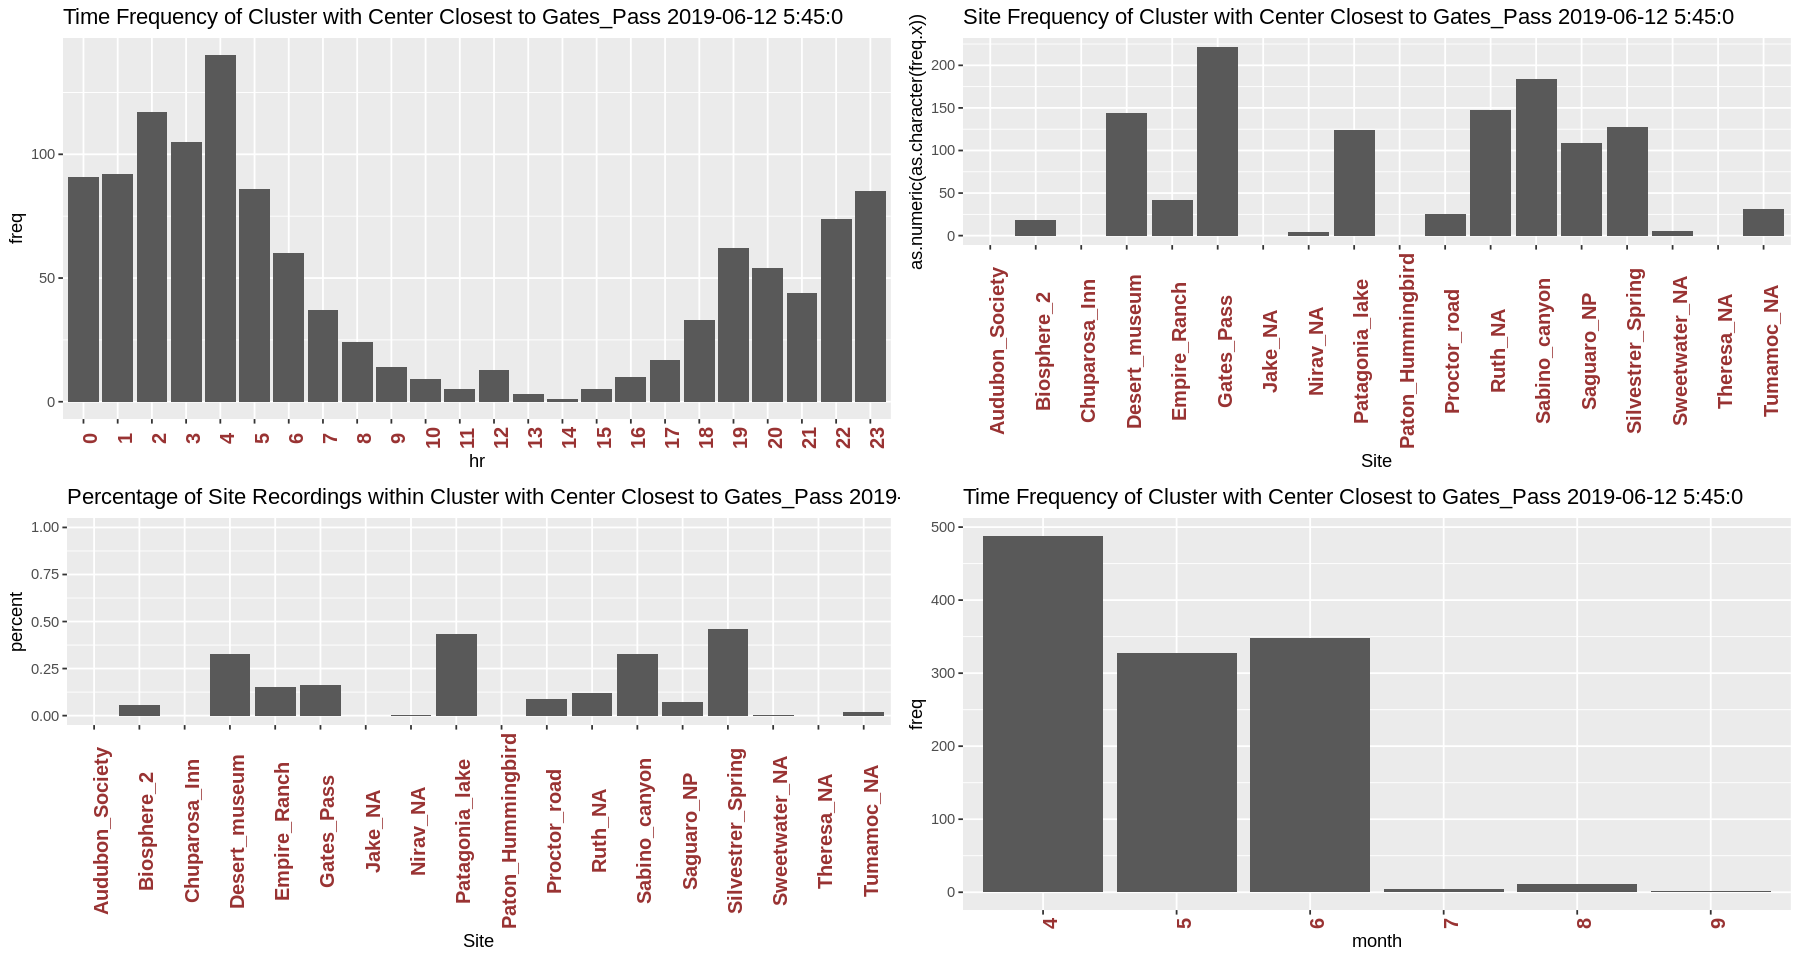

In [26]:
# K-Means Clustering with 10 clusters
fit <- kmeans(index_data[,7:16],15,iter.max=30)
fit$size
fit$centers
# Cluster Plot against 1st 2 principal components

# vary parameters for most readable graph
clusplot(index_data[,7:16], fit$cluster, color=FALSE, shade=FALSE,
   labels=2, lines=0)

histogram_plotter(fit,data.frame(index_data, fit$cluster) )

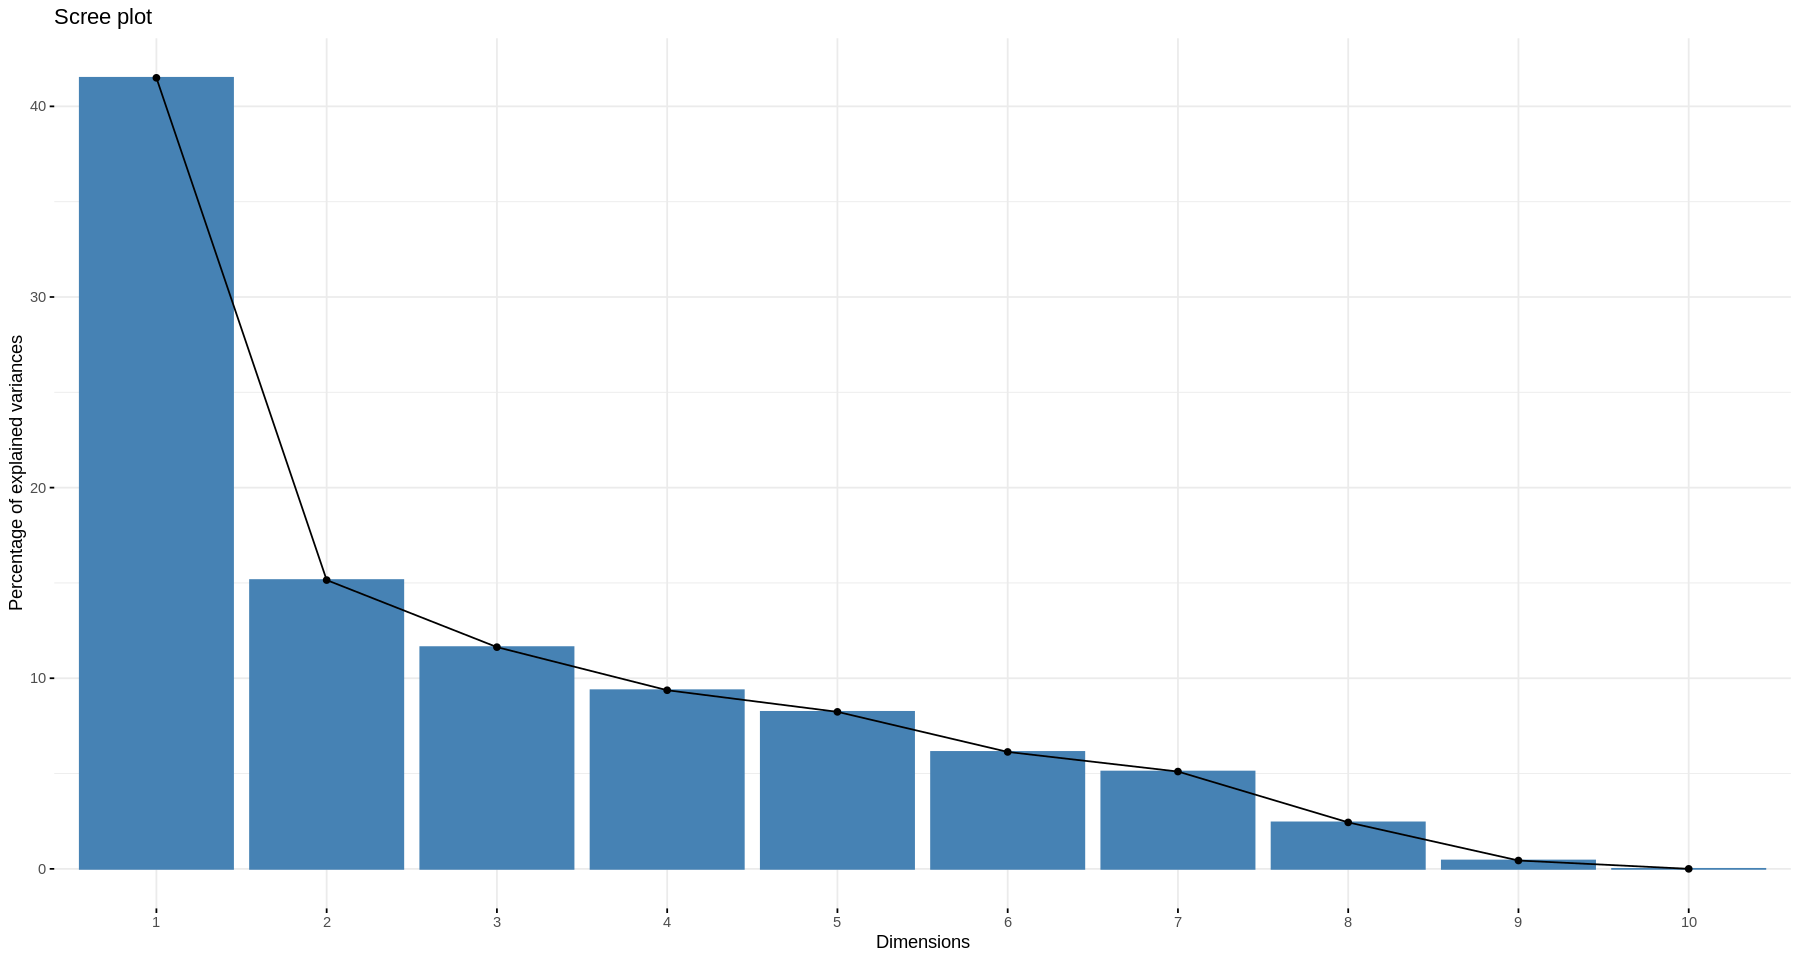

In [34]:
indices.pca <- prcomp(index_data[,7:16], scale = TRUE)
fviz_eig(indices.pca)

Scatterplots for every pair of bioindices. The colorings represent the month of the data point and the hour of the day, respectively. 

CAUTION: This may not be a good visualization of the class makeup; some classes may be covering up others; Analyse colorings with care!

The almost perfect correlation between spectral entropy and acoustic entropy suggests we should drop one of them. 

There is obviously some dependency between acoustic diversity and acoustic evenness, but it is not clear if dropping one of them would reduce the efficacy of the clustering/PCA. I believe that because a powerful enough neural net should be able to implicitly transform one of these indices into the other, it is likely that dropping one of them should not worsen performance of any sort of neural model. 

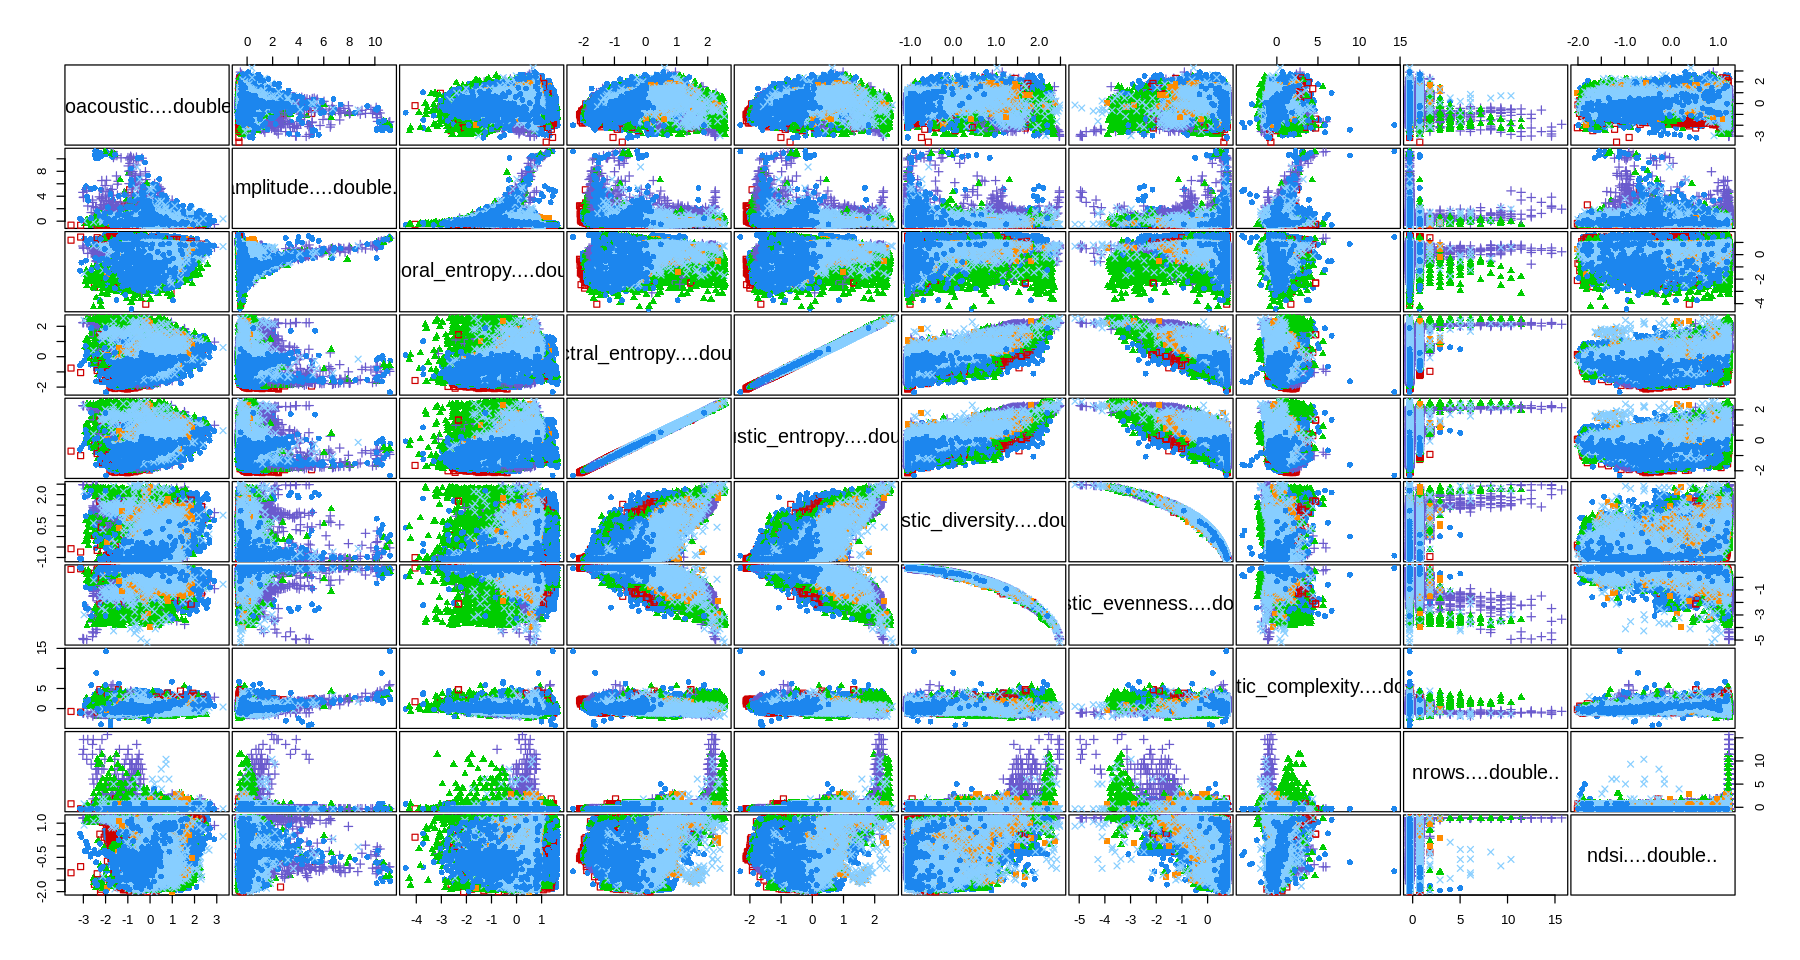

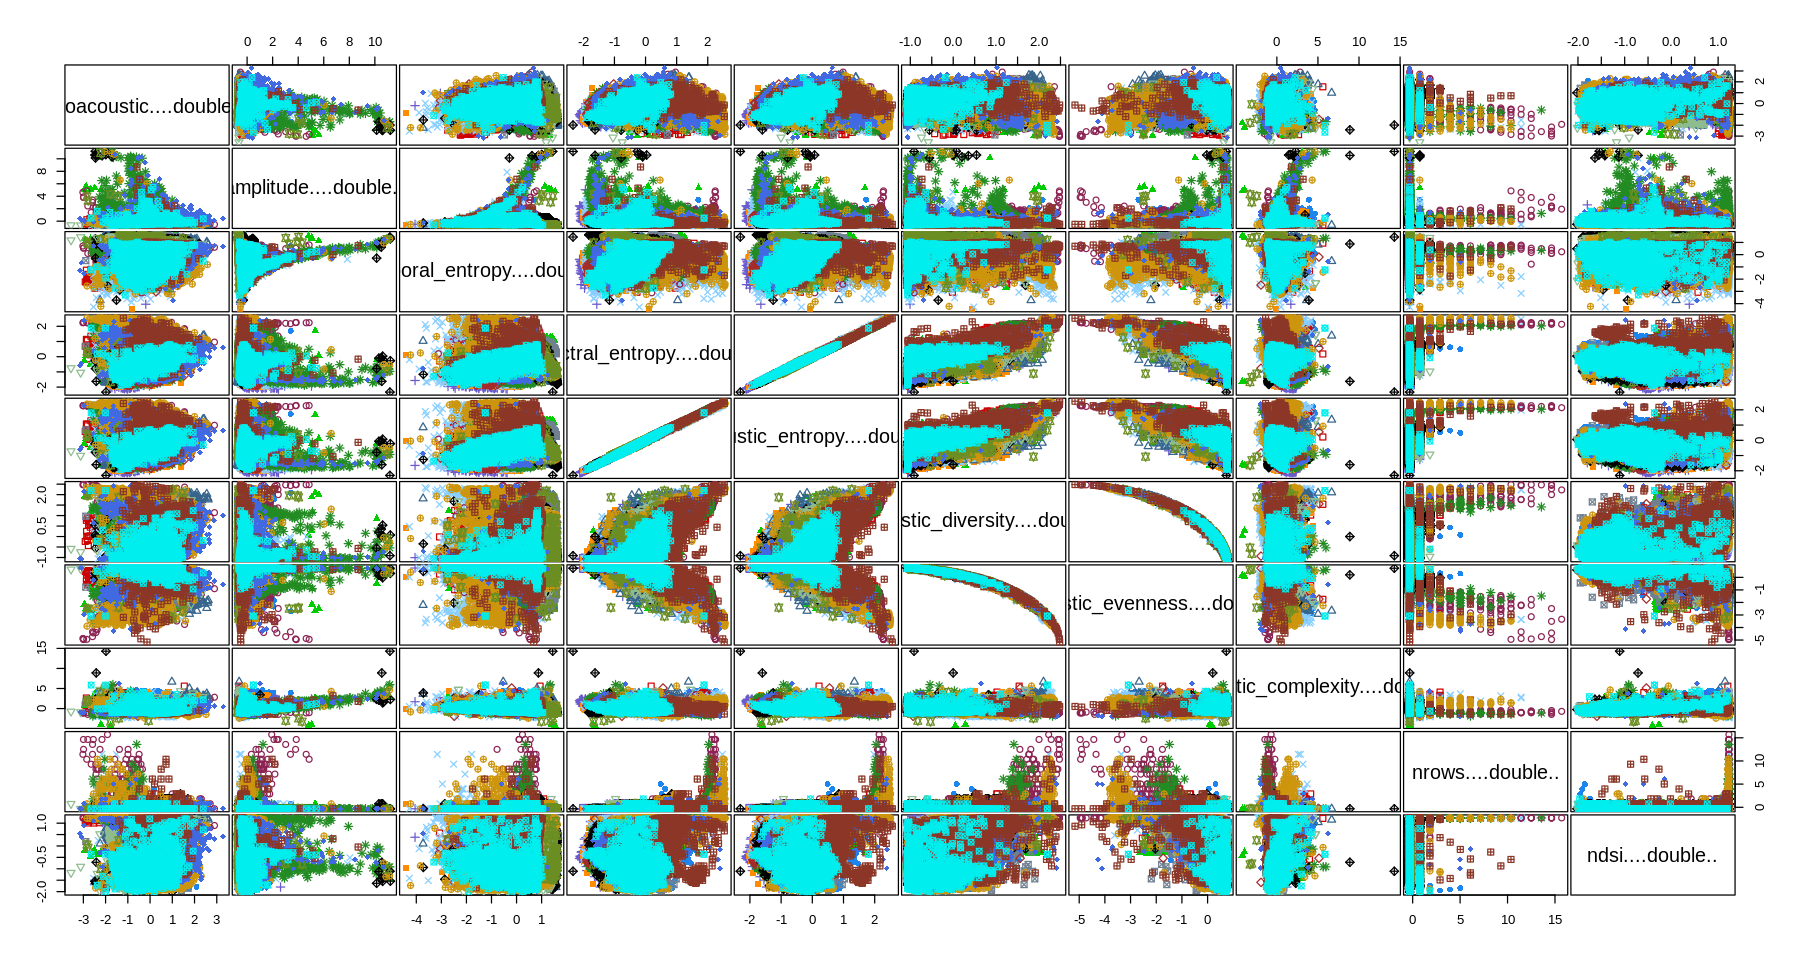

In [37]:
months <- sapply(index_data$Date....as.Date.character....format.....Y..m..d..,month_getter)
clPairs(index_data[,7:16],months)
clPairs(index_data[,7:16],index_data$Site)

In [40]:
mix_fit <- Mclust(index_data[,7:16])
mix_fit

'Mclust' model object: (EEV,9) 

Available components: 
 [1] "call"           "data"           "modelName"      "n"             
 [5] "d"              "G"              "BIC"            "loglik"        
 [9] "df"             "bic"            "icl"            "hypvol"        
[13] "parameters"     "z"              "classification" "uncertainty"   

In [46]:
mix_fit$parameters

$pro
[1] 0.159907498 0.001419144 0.005629733 0.629779966 0.009683609 0.001135279
[7] 0.165641003 0.017558532 0.009245236

$mean
                                      [,1]        [,2]       [,3]        [,4]
bioacoustic....double..          0.1352312  0.19294186  0.7408867  0.07029798
amplitude....double..           -0.1618184  0.06818025 -0.3139940 -0.16025135
temporal_entropy....double..     0.3338970  0.04318877  0.6580000 -0.06472773
spectral_entropy....double..     0.4601410  0.64123968  0.7608162 -0.42912610
acoustic_entropy....double..     0.4711517  0.63828547  0.7869756 -0.42906860
acoustic_diversity....double..   0.4431380  0.49677613  0.8281672 -0.48995487
acoustic_evenness....double..   -0.2272567 -0.18368245 -0.4652324  0.47265802
acoustic_complexity....double.. -0.3498809  0.35714191 -0.2680023 -0.08943150
nrows....double..                0.7502799  1.76492746  1.9214577 -0.31777008
ndsi....double..                 0.4509614  0.73656514  0.9615120 -0.37951052
                                       [,5]        [,6]       [,7]       [,8]
bioacoustic....double..          0.91527658  0.32539873 -0.2838386 -1.1428832
amplitude....double..           -0.26022586 -0.14773474  0.7194026  0.6565627
temporal_entropy....double..     1.18407397  0.56107388 -0.1356891  0.2331759
spectral_entropy....double..     1.16008803  0.54631588  0.7288474  2.0866235
acoustic_entropy....double..     1.21320598  0.56673154  0.7175198  2.0928698
acoustic_diversity....double..   1.72826443  0.09671292  1.0018464  1.6753980
acoustic_evenness....double..   -1.90010628  0.19109157 -1.0543256 -2.0021082
acoustic_complexity....double.. -0.76421455 -0.28492337  0.7286522 -0.7056164
nrows....double..               -0.04327503  2.15208106 -0.3177701  4.9389916
ndsi....double..                -0.21010237  0.31471148  0.7935985  1.1627122
                                       [,9]
bioacoustic....double..         -1.35112617
amplitude....double..            0.05049116
temporal_entropy....double..    -1.09415324
spectral_entropy....double..     2.40801757
acoustic_entropy....double..     2.33112505
acoustic_diversity....double..   2.17683092
acoustic_evenness....double..   -3.29619852
acoustic_complexity....double..  1.37275239
nrows....double..                3.32257812
ndsi....double..                 1.10834929

$variance
$variance$modelName
[1] "EEV"

$variance$d
[1] 10

$variance$G
[1] 9

$variance$sigma
, , 1

                                bioacoustic....double.. amplitude....double..
bioacoustic....double..                    1.165096e+00         -4.909947e-02
amplitude....double..                     -4.909947e-02          2.886141e-01
temporal_entropy....double..               1.936038e-01         -1.181537e-01
spectral_entropy....double..               1.137160e-01          5.830721e-02
acoustic_entropy....double..               1.232849e-01          5.359256e-02
acoustic_diversity....double..             7.571994e-02          2.242475e-02
acoustic_evenness....double..              6.777761e-03         -4.547079e-02
acoustic_complexity....double..            1.733049e-01          1.565518e-01
nrows....double..                         -3.798176e-30          1.135024e-28
ndsi....double..                          -1.375171e-01         -1.113555e-01
                                temporal_entropy....double..
bioacoustic....double..                         1.936038e-01
amplitude....double..                          -1.181537e-01
temporal_entropy....double..                    4.323425e-01
spectral_entropy....double..                   -3.115182e-02
acoustic_entropy....double..                   -1.366916e-02
acoustic_diversity....double..                  3.424533e-02
acoustic_evenness....double..                   9.458613e-03
acoustic_complexity....double..                -1.143174e-01
nrows....double..                               1.235311e-28
ndsi....double..                                8.191588e-02
                                spectra

The $pro vector indicates the mixing proportion of the optimal model is less than 1% 